# Simulazioni per TSP e KP

All'interno di questo file è contenuto tutto il codice sorgente utilizzato all'interno della tesi. Non mostra il lavoro effettuato nella sua interezza, ma ne evidenzia le parti più importanti e che vengono discusse, commentate e mostrate.

## Algoritmi esatti

Mostriamo i tempi di esecuzione di alcuni algoritmi esatti per il KP.


Benchmarking Brute Force...
Dimensione: 3 oggetti, Tempo medio: 0.0000 s
Dimensione: 4 oggetti, Tempo medio: 0.0000 s
Dimensione: 5 oggetti, Tempo medio: 0.0000 s
Dimensione: 6 oggetti, Tempo medio: 0.0001 s
Dimensione: 7 oggetti, Tempo medio: 0.0001 s
Dimensione: 8 oggetti, Tempo medio: 0.0003 s
Dimensione: 9 oggetti, Tempo medio: 0.0007 s
Dimensione: 10 oggetti, Tempo medio: 0.0013 s
Dimensione: 11 oggetti, Tempo medio: 0.0030 s
Dimensione: 12 oggetti, Tempo medio: 0.0069 s
Dimensione: 13 oggetti, Tempo medio: 0.0144 s
Dimensione: 14 oggetti, Tempo medio: 0.0311 s
Dimensione: 15 oggetti, Tempo medio: 0.0673 s
Dimensione: 16 oggetti, Tempo medio: 0.0711 s
Dimensione: 17 oggetti, Tempo medio: 0.1452 s
Dimensione: 18 oggetti, Tempo medio: 0.3082 s
Dimensione: 19 oggetti, Tempo medio: 0.6655 s
Dimensione: 20 oggetti, Tempo medio: 1.4274 s

Benchmarking Branch and Bound...
Dimensione: 100 oggetti, Tempo medio: 0.0011 s
Dimensione: 400 oggetti, Tempo medio: 0.0114 s
Dimensione: 700 oggett

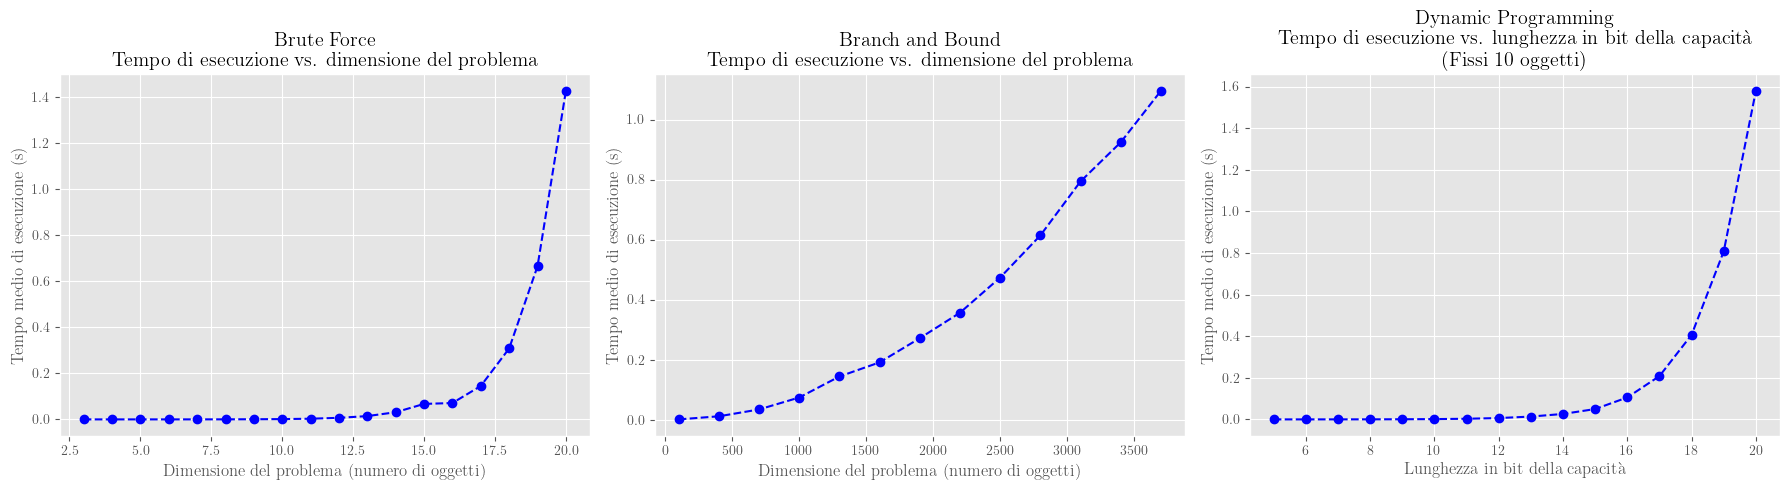

In [68]:
import time
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ---------------------------
# Configurazione e Seme
# ---------------------------
np.random.seed(1234)
executions_per_instance = 8   # Numero di esecuzioni per istanza

# ---------------------------
# Algoritmi esatti per il problema dello zaino
# ---------------------------
def brute_force_knapsack(values, weights, capacity):
    """
    Soluzione brute-force enumerando tutti i possibili sottoinsiemi.
    """
    n = len(values)
    best_value = -1
    for i in range(2 ** n):
        tot_weight = 0
        tot_value = 0
        for j in range(n):
            if i & (1 << j):
                tot_weight += weights[j]
                tot_value += values[j]
        if tot_weight <= capacity and tot_value > best_value:
            best_value = tot_value
    return best_value

def dp_knapsack(values, weights, capacity):
    """
    Soluzione di programmazione dinamica per il problema dello zaino 0/1
    utilizzando un array DP monodimensionale.
    La complessità temporale è O(n*capacità), quindi se la capacità raddoppia,
    il tempo di esecuzione raddoppia approssimativamente.
    """
    n = len(values)
    dp = [0] * (capacity + 1)
    for i in range(n):
        # Processa i pesi in ordine inverso per garantire che ogni oggetto sia usato al massimo una volta
        for w in range(capacity, weights[i] - 1, -1):
            dp[w] = max(dp[w], dp[w - weights[i]] + values[i])
    return dp[capacity]

# Implementazione dell'algoritmo Branch and Bound
# da https://www.geeksforgeeks.org/0-1-knapsack-using-branch-and-bound/
from queue import PriorityQueue

class Item:
    def __init__(self, weight, value):
        self.weight = weight
        self.value = value

class Node:
    def __init__(self, level, profit, weight):
        self.level = level      # Livello del nodo nell'albero decisionale (o indice in arr[])
        self.profit = profit    # Profitto accumulato dal nodo radice fino a questo nodo (incluso questo nodo)
        self.weight = weight    # Peso totale al nodo

    def __lt__(self, other):
        return other.weight < self.weight  # Confronta in base al peso in ordine decrescente

def bound(u, n, W, arr):
    # Calcola il limite superiore del profitto per un nodo nell'albero di ricerca
    if u.weight >= W:
        return 0

    profit_bound = u.profit
    j = u.level + 1
    total_weight = u.weight

    # Aggiungi avidamente gli oggetti nello zaino finché non viene raggiunto il limite di peso
    while j < n and total_weight + arr[j].weight <= W:
        total_weight += arr[j].weight
        profit_bound += arr[j].value
        j += 1

    # Se ci sono ancora oggetti disponibili, calcola il contributo frazionario del prossimo oggetto
    if j < n:
        profit_bound += int((W - total_weight) * arr[j].value / arr[j].weight)

    return profit_bound

def branch_and_bound_knapsack(values, weights, capacity):
    W = capacity
    arr = [Item(weights[i], values[i]) for i in range(len(values))]
    n = len(arr)
    # Ordina gli oggetti in base al rapporto valore/peso in ordine non decrescente
    arr.sort(key=lambda x: x.value / x.weight, reverse=True)
    
    priority_queue = PriorityQueue()
    u = Node(-1, 0, 0)  # Nodo fittizio all'inizio
    priority_queue.put(u)

    max_profit = 0

    while not priority_queue.empty():
        u = priority_queue.get()

        if u.level == -1:
            v = Node(0, 0, 0)  # Nodo iniziale
        elif u.level == n - 1:
            continue  # Salta se è l'ultimo livello (nessun altro oggetto da considerare)
        else:
            v = Node(u.level + 1, u.profit, u.weight)  # Nodo senza considerare il prossimo oggetto

        v.weight += arr[v.level].weight
        v.profit += arr[v.level].value

        # Se il peso accumulato è minore o uguale a W e il profitto è maggiore del profitto precedente, aggiorna max_profit
        if v.weight <= W and v.profit > max_profit:
            max_profit = v.profit

        v_bound = bound(v, n, W, arr)
        # Se il valore limite è maggiore dell'attuale max_profit, aggiungi il nodo alla coda di priorità per ulteriori considerazioni
        if v_bound > max_profit:
            priority_queue.put(v)

        # Nodo che considera il prossimo oggetto senza aggiungerlo allo zaino
        v = Node(u.level + 1, u.profit, u.weight)
        v_bound = bound(v, n, W, arr)
        # Se il valore limite è maggiore dell'attuale max_profit, aggiungi il nodo alla coda di priorità per ulteriori considerazioni
        if v_bound > max_profit:
            priority_queue.put(v)

    return max_profit

# Dizionario degli algoritmi esatti
exact_methods = {
    "Brute Force": brute_force_knapsack,
    "Branch and Bound": branch_and_bound_knapsack,
    "Dynamic Programming": dp_knapsack
}

# Definisci le dimensioni iniziali delle istanze e gli incrementi per Brute Force e Branch and Bound
initial_sizes = {
    "Brute Force": 3,          # inizia con valori piccoli per brute force
    "Branch and Bound": 100    # inizia con 100 oggetti per branch and bound
}
step_sizes = {
    "Brute Force": 1,
    "Branch and Bound": 300
}

# ---------------------------
# Benchmark e Grafici: Un grafico per algoritmo in un'unica figura
# ---------------------------
# Crea una figura con 3 subplot affiancati
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
ax_index = 0

for method_name, method_function in exact_methods.items():
    if method_name == "Dynamic Programming":
        # Per DP, fissa il numero di oggetti e varia la capacità aumentando la lunghezza in bit
        sizes = []       # 'sizes' conterrà la lunghezza in bit della capacità
        avg_times = []
        fixed_n = 10   # numero fisso di oggetti
        bit_length = 5  # lunghezza in bit iniziale (capacità = 2^5 = 32)
        print(f"\nBenchmarking {method_name} con {fixed_n} oggetti fissi e capacità variabile (lunghezza in bit)...")
        while True:
            capacity = 2 ** bit_length
            times = []
            for _ in range(executions_per_instance):
                # Genera un'istanza casuale con un numero fisso di oggetti
                values = np.random.randint(1, 11, size=fixed_n).tolist()
                weights = np.random.randint(1, 6, size=fixed_n).tolist()
                start = time.time()
                _ = method_function(values, weights, capacity)
                end = time.time()
                times.append(end - start)
            avg_time = np.mean(times)
            sizes.append(bit_length)
            avg_times.append(avg_time)
            print(f"Lunghezza in bit: {bit_length}, Capacità: {capacity}, Tempo medio: {avg_time:.4f} s")
            if avg_time > 1:
                break
            bit_length += 1
        # Grafico per Dynamic Programming (asse x: lunghezza in bit della capacità)
        axs[ax_index].plot(sizes, avg_times, marker='o', linestyle='--', color='blue')
        axs[ax_index].set_xlabel("Lunghezza in bit della capacità")
        axs[ax_index].set_ylabel("Tempo medio di esecuzione (s)")
        axs[ax_index].set_title(f"{method_name}\nTempo di esecuzione vs. lunghezza in bit della capacità\n(Fissi {fixed_n} oggetti)")
        axs[ax_index].grid(True)
    else:
        # Per Brute Force e Branch and Bound, varia il numero di oggetti
        sizes = []
        avg_times = []
        instance_size = initial_sizes[method_name]
        print(f"\nBenchmarking {method_name}...")
        while True:
            times = []
            for _ in range(executions_per_instance):
                # Genera un'istanza casuale:
                # - valori: numeri casuali tra 1 e 10
                # - pesi: numeri casuali tra 1 e 5
                values = np.random.randint(1, 11, size=instance_size).tolist()
                weights = np.random.randint(1, 6, size=instance_size).tolist()
                capacity = int(sum(weights) / 2)
                if capacity == 0:
                    capacity = 1
                start = time.time()
                _ = method_function(values, weights, capacity)
                end = time.time()
                times.append(end - start)
            avg_time = np.mean(times)
            sizes.append(instance_size)
            avg_times.append(avg_time)
            print(f"Dimensione: {instance_size} oggetti, Tempo medio: {avg_time:.4f} s")
            if avg_time > 1:
                break
            instance_size += step_sizes[method_name]
        # Grafico per l'algoritmo corrente (asse x: numero di oggetti)
        axs[ax_index].plot(sizes, avg_times, marker='o', linestyle='--', color='blue')
        axs[ax_index].set_xlabel("Dimensione del problema (numero di oggetti)")
        axs[ax_index].set_ylabel("Tempo medio di esecuzione (s)")
        axs[ax_index].set_title(f"{method_name}\nTempo di esecuzione vs. dimensione del problema")
        axs[ax_index].grid(True)
    ax_index += 1

plt.tight_layout()
plt.show()


## Algoritmi euristici

Mostriamo i tempi di esecuzione e l'errore relativo di alcuni algoritmi euristici per il KP.


===== Esecuzione per l'algoritmo Greedy Ratio =====

===== Esecuzione per l'algoritmo Greedy Value =====

===== Esecuzione per l'algoritmo Random =====

===== Esecuzione per l'algoritmo FPTAS =====

===== Esecuzione per l'algoritmo Simulated Annealing =====


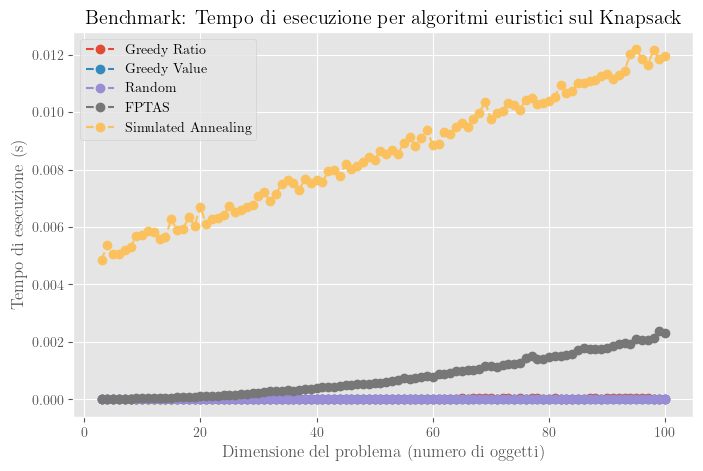

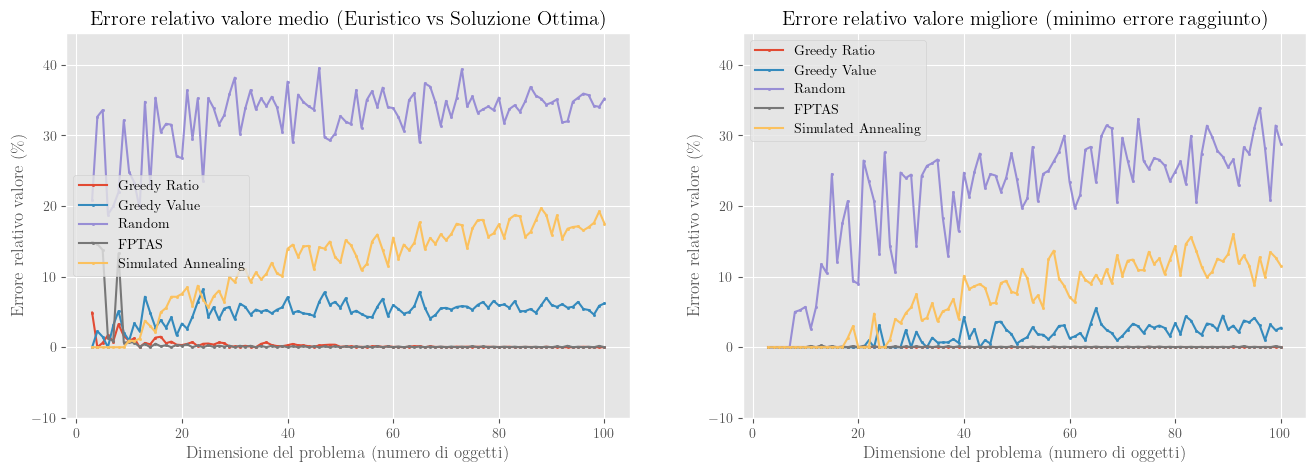

In [84]:
import time
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ---------------------------
# Configurazione iniziale e seed
# ---------------------------
np.random.seed(1234)
# Numero di esecuzioni per ciascuna dimensione del problema
heuristic_executions_per_instance = 8
# Dimensioni del problema (numero di oggetti)
min_items = 3
max_items = 100
item_steps = 1

# ---------------------------
# Definizione degli algoritmi euristici per il Knapsack
# ---------------------------
def greedy_ratio(values, weights, capacity):
    """
    Algoritmo Greedy basato sul rapporto valore/peso.
    Ordina gli oggetti in ordine decrescente del rapporto e aggiunge
    l'oggetto se rientra nella capacità residua.
    """
    ratios = [v / w for v, w in zip(values, weights)]
    sorted_indices = sorted(range(len(values)), key=lambda i: ratios[i], reverse=True)
    chosen = []
    total_weight = 0
    total_value = 0
    for i in sorted_indices:
        if total_weight + weights[i] <= capacity:
            chosen.append(i)
            total_weight += weights[i]
            total_value += values[i]
    return chosen, total_value, total_weight

def greedy_value(values, weights, capacity):
    """
    Algoritmo Greedy che seleziona gli oggetti in base al valore decrescente.
    """
    sorted_indices = sorted(range(len(values)), key=lambda i: values[i], reverse=True)
    chosen = []
    total_weight = 0
    total_value = 0
    for i in sorted_indices:
        if total_weight + weights[i] <= capacity:
            chosen.append(i)
            total_weight += weights[i]
            total_value += values[i]
    return chosen, total_value, total_weight

def random_selection(values, weights, capacity):
    """
    Algoritmo euristico che seleziona casualmente gli oggetti.
    Gli oggetti vengono mescolati e aggiunti se rientrano nella capacità.
    """
    indices = list(range(len(values)))
    np.random.shuffle(indices)
    chosen = []
    total_weight = 0
    total_value = 0
    for i in indices:
        if total_weight + weights[i] <= capacity:
            chosen.append(i)
            total_weight += weights[i]
            total_value += values[i]
    return chosen, total_value, total_weight

def fptas_knapsack(values, weights, capacity, epsilon=0.2):
    """
    Algoritmo FPTAS per il problema dello zaino.
    Utilizza una tecnica di scaling dei valori per ridurre la complessità
    della programmazione dinamica, ottenendo una soluzione approssimata.
    """
    n = len(values)
    if n == 0:
        return [], 0, 0
    vmax = max(values)
    K = epsilon * vmax / n
    # Scaling dei valori
    if K == 0:
        scaled = values
    else:
        scaled = [int(np.floor(v / K)) for v in values]
    
    # Programmazione dinamica approssimata
    # Uso la funzione solve_knapsack_exact per ottenere la soluzione ottima
    _, chosen, total_value = solve_knapsack_exact(scaled, weights, capacity)
    total_value = total_value * K
    total_weight = sum(weights[i] for i in chosen)
    
    return chosen, total_value, total_weight

def simulated_annealing_knapsack(values, weights, capacity,
                                 initial_temperature=1000,
                                 cooling_rate=0.99,
                                 iterations=1000,
                                 penalty=10):
    """
    Algoritmo Simulated Annealing per il problema dello zaino.
    
    La funzione definisce una soluzione come un vettore binario di lunghezza n.
    L'obiettivo (da massimizzare) è il valore totale degli oggetti, penalizzato se
    il peso totale supera la capacità.
    
    Parametri:
      - initial_temperature: temperatura iniziale
      - cooling_rate: fattore di raffreddamento ad ogni iterazione
      - iterations: numero di iterazioni per la ricerca
      - penalty: fattore di penalizzazione per il peso in eccesso
      
    Restituisce:
      - chosen: lista degli indici degli oggetti selezionati
      - total_value: valore totale ottenuto
      - total_weight: peso totale degli oggetti selezionati
    """
    n = len(values)
    
    # Funzione obiettivo: se la soluzione è fattibile, l'obiettivo è il valore totale;
    # altrimenti, penalizza il valore in base all'eccesso di peso.
    def objective(solution):
        total_weight = sum(weights[i] for i in range(n) if solution[i] == 1)
        total_value = sum(values[i] for i in range(n) if solution[i] == 1)
        if total_weight <= capacity:
            return total_value
        else:
            return total_value - penalty * (total_weight - capacity)
    
    # Funzione per generare un vicino: flip di una posizione casuale
    def neighbor(solution):
        new_solution = solution.copy()
        i = np.random.randint(0, n)
        new_solution[i] = 1 - new_solution[i]  # flip
        return new_solution
    
    # Inizializzazione: partiamo da una soluzione vuota (tutti 0)
    current_solution = [0] * n
    current_obj = objective(current_solution)
    best_solution = current_solution.copy()
    best_obj = current_obj
    temperature = initial_temperature
    
    for _ in range(iterations):
        new_solution = neighbor(current_solution)
        new_obj = objective(new_solution)
        delta = new_obj - current_obj
        if delta > 0 or np.random.rand() < np.exp(delta / temperature):
            current_solution = new_solution
            current_obj = new_obj
            if current_obj > best_obj:
                best_solution = current_solution.copy()
                best_obj = current_obj
        temperature *= cooling_rate
    
    # Conversione della soluzione binaria in lista di indici
    chosen = [i for i in range(n) if best_solution[i] == 1]
    total_weight = sum(weights[i] for i in chosen)
    total_value = sum(values[i] for i in chosen)
    return chosen, total_value, total_weight

# Collezione di algoritmi euristici; in futuro potrai aggiungerne altri
heuristic_algorithms = {
    "Greedy Ratio": greedy_ratio,
    "Greedy Value": greedy_value,
    "Random": random_selection,
    "FPTAS": fptas_knapsack,
    "Simulated Annealing": simulated_annealing_knapsack
}

# ---------------------------
# Funzione per risolvere il Knapsack in modo esatto (dinamic programming)
# per ottenere la soluzione ottima di riferimento
# ---------------------------
def solve_knapsack_exact(values, weights, capacity):
    n = len(values)
    dp = [0] * (capacity + 1)
    for i in range(n):
        # Processa i pesi in ordine inverso per garantire che ogni oggetto sia usato al massimo una volta
        for w in range(capacity, weights[i] - 1, -1):
            dp[w] = max(dp[w], dp[w - weights[i]] + values[i])
    return dp[capacity], [i for i in range(n) if dp[capacity] == dp[capacity - weights[i]] + values[i]], dp[capacity]

# ---------------------------
# Inizializzazione dei dizionari per le metriche
# ---------------------------
execution_times_dict = {algo: {} for algo in heuristic_algorithms.keys()}
value_error_dict = {algo: {} for algo in heuristic_algorithms.keys()}       # errore valore medio (%)
value_error_best_dict = {algo: {} for algo in heuristic_algorithms.keys()}  # errore valore migliore (%)

# ---------------------------
# Ciclo sperimentale per ciascun algoritmo euristico e per ogni dimensione del problema
# Per ogni esecuzione, viene generata una nuova istanza casuale.
# ---------------------------
for algo_name, algo_function in heuristic_algorithms.items():
    print(f"\n===== Esecuzione per l'algoritmo {algo_name} =====")
    for num_items in range(min_items, max_items + 1, item_steps):
        times_list = []
        value_error_list = []
        for exec_num in range(heuristic_executions_per_instance):
            # Generazione casuale dell'istanza del Knapsack
            values = np.random.randint(1, 11, size=num_items).tolist()    # valori da 1 a 10
            weights = np.random.randint(1, 6, size=num_items).tolist()      # pesi da 1 a 5
            capacity = int(sum(weights) / 2)
            if capacity == 0:
                capacity = 1

            # Risoluzione esatta per ottenere la soluzione ottima
            _, _, optimal_value = solve_knapsack_exact(values, weights, capacity)
            
            # Esecuzione dell'algoritmo euristico e misurazione del tempo
            start_time = time.time()
            chosen_items, heuristic_value, heuristic_weight = algo_function(values, weights, capacity)
            elapsed_time = time.time() - start_time
            
            # Se la soluzione violasse i vincoli, imposto il valore a 0
            if heuristic_weight > capacity:
                heuristic_value = 0
            
            # Calcolo dell'errore relativo sul valore rispetto all'ottimo
            rel_error_value = abs(optimal_value - heuristic_value) / abs(optimal_value) if optimal_value != 0 else 0
            value_error_percent = rel_error_value * 100
            
            times_list.append(elapsed_time)
            value_error_list.append(value_error_percent)
        
        # Calcolo delle metriche per la dimensione corrente
        avg_time = np.mean(times_list)
        avg_value_error = np.mean(value_error_list)
        best_value_error = np.min(value_error_list)
        
        execution_times_dict[algo_name][num_items] = avg_time
        value_error_dict[algo_name][num_items] = avg_value_error
        value_error_best_dict[algo_name][num_items] = best_value_error

# ---------------------------
# Grafici comparativi per ciascuna metrica e per ciascun algoritmo euristico
# ---------------------------
problem_sizes = list(range(min_items, max_items + 1, item_steps))
plt.style.use('ggplot')

# Grafico 1: Tempo di esecuzione medio
plt.figure(figsize=(8, 5))
for algo in heuristic_algorithms.keys():
    times = [execution_times_dict[algo][n] for n in problem_sizes]
    plt.plot(problem_sizes, times, marker='o', linestyle='--', label=f"{algo}")
plt.xlabel("Dimensione del problema (numero di oggetti)")
plt.ylabel("Tempo di esecuzione (s)")
plt.title("Benchmark: Tempo di esecuzione per algoritmi euristici sul Knapsack")
plt.legend()
plt.grid(True)
plt.show()

# Grafici 2 e 3: Errore relativo sul valore medio e migliore (affiancati)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
# Grafico 2: Errore relativo valore medio (%)
for algo in heuristic_algorithms.keys():
    errors_avg = [value_error_dict[algo][n] for n in problem_sizes]
    axes[0].plot(problem_sizes, errors_avg, marker='s', markersize=1, linestyle='-', label=f"{algo}")
axes[0].set_xlabel("Dimensione del problema (numero di oggetti)")
axes[0].set_ylabel("Errore relativo valore (\%)")
axes[0].set_title("Errore relativo valore medio (Euristico vs Soluzione Ottima)")
axes[0].legend()
axes[0].grid(True)

# Grafico 3: Errore relativo valore migliore (%)
for algo in heuristic_algorithms.keys():
    errors_best = [value_error_best_dict[algo][n] for n in problem_sizes]
    axes[1].plot(problem_sizes, errors_best, marker='s', markersize=1, linestyle='-', label=f"{algo}")
axes[1].set_xlabel("Dimensione del problema (numero di oggetti)")
axes[1].set_ylabel("Errore relativo valore (\%)")
axes[1].set_title("Errore relativo valore migliore (minimo errore raggiunto)")
axes[1].legend()
axes[1].grid(True)

# Imposto lo stesso intervallo sull'asse y per entrambi i grafici
all_value_errors = (
    [value_error_dict[a][n] for a in heuristic_algorithms.keys() for n in problem_sizes] +
    [value_error_best_dict[a][n] for a in heuristic_algorithms.keys() for n in problem_sizes]
)
max_value_error = max(all_value_errors)
min_value_error = min(all_value_errors)
axes[0].set_ylim(min(-5, min_value_error-10), max_value_error+5)
axes[1].set_ylim(min(-5, min_value_error-10), max_value_error+5)

plt.show()


## Simulazioni del VQE

In seguito vi sono simulazioni e risultati per le nostre prove eseguite con il VQE. Abbiamo grafici che mostrano i tempi di esecuzione e l'errore relativo sia dell'energia minima raggiunta che del valore trovato rispetto al valore esatto.

Istanze del Knapsack generate:
Numero oggetti: 3 -> Valori: [3, 3, 7], Pesi: [2, 4, 3], Capacità: 4
Numero oggetti: 4 -> Valori: [10, 7, 2, 1], Pesi: [2, 2, 1, 1], Capacità: 3
Numero oggetti: 5 -> Valori: [10, 4, 5, 1, 1], Pesi: [5, 2, 4, 3, 5], Capacità: 9
Numero oggetti: 6 -> Valori: [8, 3, 5, 9, 1, 8], Pesi: [2, 4, 5, 5, 5, 2], Capacità: 11
Numero oggetti: 7 -> Valori: [6, 7, 3, 2, 9, 4, 6], Pesi: [1, 4, 3, 3, 3, 3, 5], Capacità: 11
Numero oggetti: 8 -> Valori: [5, 7, 4, 1, 7, 5, 8, 7], Pesi: [2, 4, 3, 2, 3, 5, 1, 2], Capacità: 11

===== Esecuzione per l'Ansatz A1 =====

Esecuzione VQE per il KP con 3 oggetti, Ansatz A1

--- Esecuzione VQE numero 1/8 ---

--- Esecuzione VQE numero 2/8 ---

--- Esecuzione VQE numero 3/8 ---

--- Esecuzione VQE numero 4/8 ---

--- Esecuzione VQE numero 5/8 ---

--- Esecuzione VQE numero 6/8 ---

--- Esecuzione VQE numero 7/8 ---

--- Esecuzione VQE numero 8/8 ---

Esecuzione VQE per il KP con 4 oggetti, Ansatz A1

--- Esecuzione VQE numero 1/8 ---

--

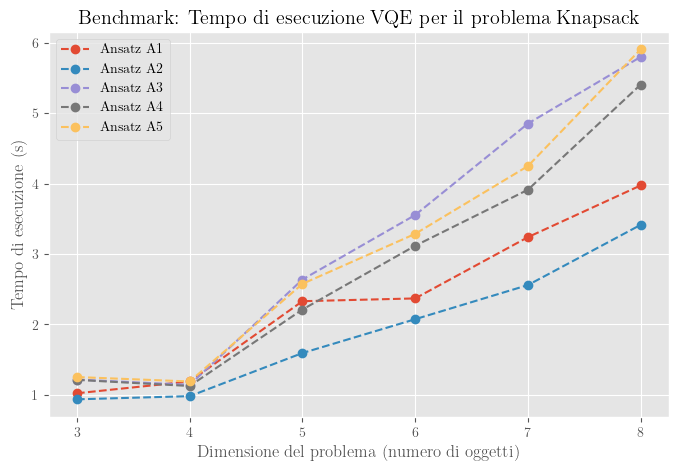

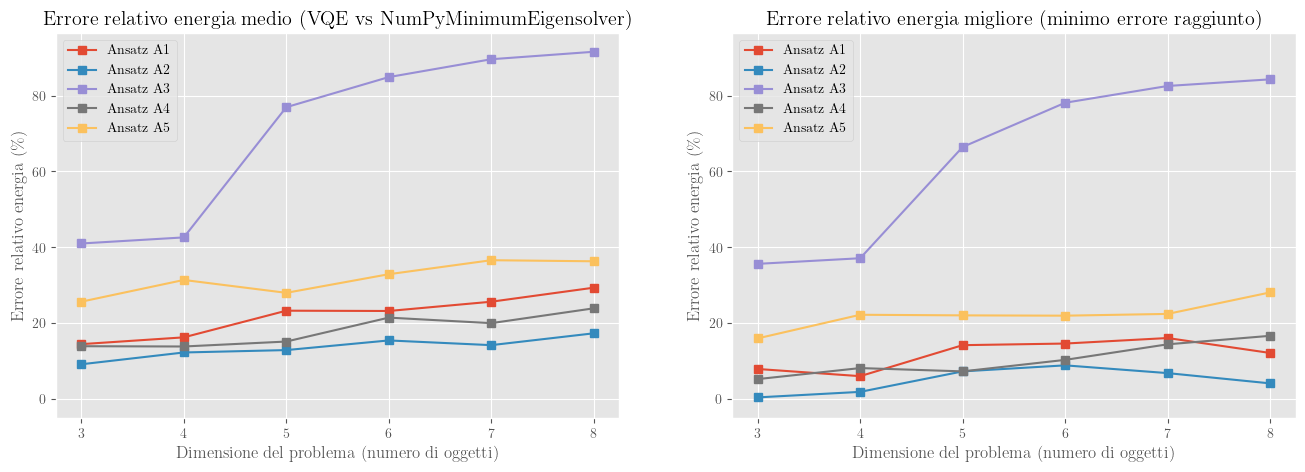

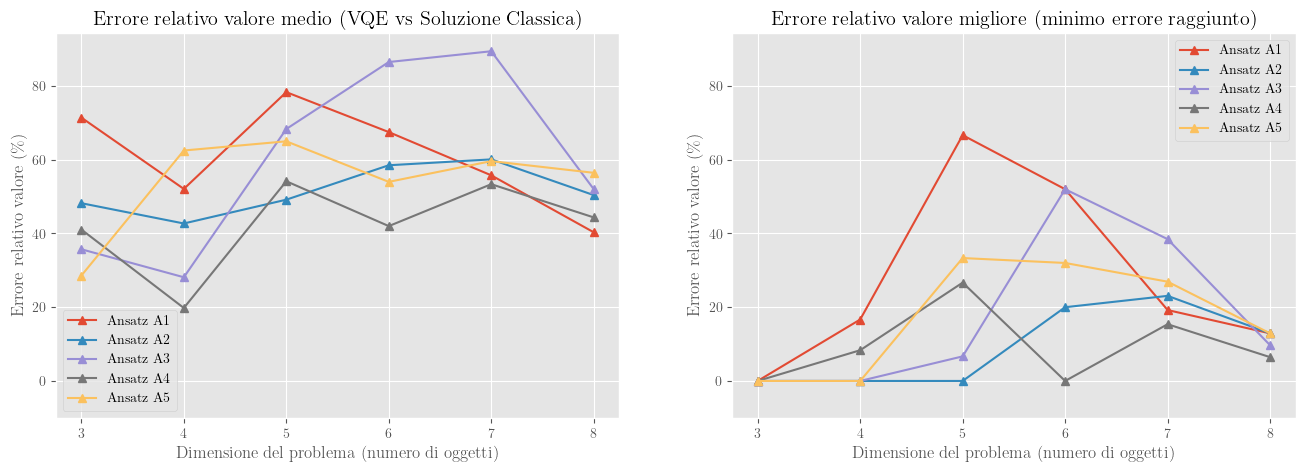

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Disabilita i warning per una visualizzazione più pulita
import warnings
warnings.filterwarnings('ignore')


# Importazioni per Qiskit Optimization e algoritmi quantistici
from qiskit_optimization.applications.knapsack import Knapsack
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_aer.primitives import Sampler
from qiskit_algorithms.utils import algorithm_globals


from matplotlib import rc

# Set del font a Computer Modern
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# ---------------------------
# Configurazione iniziale e seed
# ---------------------------
algorithm_globals.random_seed = 123
np.random.seed(123)  # Per la generazione casuale delle istanze

# Variabile per il numero di esecuzioni per istanza VQE
VQE_executions_per_instance = 8

# Parametri per la generazione delle istanze del KP
min_istanze = 3   # numero minimo di oggetti per istanza
max_istanze = 8   # numero massimo di oggetti per istanza

# ---------------------------
# Definizione di 5 diverse ansatz
# ---------------------------
def get_ansatz(ansatz_name, num_qubits):
    if ansatz_name == "A1":
        # Ansatz A1: usa solo 'rx', 2 rep, entanglement lineare
        return TwoLocal(num_qubits, ['rx'], 'cx', reps=2, entanglement='linear')
    elif ansatz_name == "A2":
        # Ansatz A2: usa solo 'ry', 2 rep, entanglement full
        return TwoLocal(num_qubits, ['ry'], 'cx', reps=2, entanglement='full')
    elif ansatz_name == "A3":
        # Ansatz A3: usa 'rx' e 'rz', 4 rep, entanglement circular
        return TwoLocal(num_qubits, ['rx', 'rz'], 'cx', reps=4, entanglement='circular')
    elif ansatz_name == "A4":
        # Ansatz A4: usa 'ry' e 'rz', 3 rep, entanglement full
        return TwoLocal(num_qubits, ['ry', 'rz'], 'cx', reps=3, entanglement='full')
    elif ansatz_name == "A5":
        # Ansatz A5: usa 'rx' e 'ry', 4 rep, entanglement circular
        return TwoLocal(num_qubits, ['rx', 'ry'], 'cz', reps=4, entanglement='circular')
    else:
        raise ValueError("Ansatz non riconosciuto")

# ---------------------------
# Generazione casuale delle istanze del Knapsack
# ---------------------------
knapsack_instances = {}
print("Istanze del Knapsack generate:")
for n in range(min_istanze, max_istanze + 1):
    values = np.random.randint(1, 11, size=n).tolist()   # valori casuali da 1 a 10
    weights = np.random.randint(1, 6, size=n).tolist()     # pesi casuali da 1 a 5
    capacity = int(sum(weights) / 2)
    if capacity == 0:
        capacity = 1
    knapsack_instances[n] = (values, weights, capacity)
    print(f"Numero oggetti: {n} -> Valori: {values}, Pesi: {weights}, Capacità: {capacity}")

# ---------------------------
# Funzione per risolvere un'istanza del Knapsack con VQE
# ---------------------------
def solve_knapsack_instance_VQE(values, weights, capacity, ansatz_name):
    # 1. Creazione del modello: costruzione del problema KP
    knapsack_app = Knapsack(values, weights, capacity)
    qp = knapsack_app.to_quadratic_program()
    
    # 2. Conversione in QUBO e in problema Ising
    qubo_converter = QuadraticProgramToQubo()
    qubo = qubo_converter.convert(qp)
    qubit_op, offset = qubo.to_ising()
    
    # 3. Definizione dell'ansatz in base al tipo scelto
    ansatz = get_ansatz(ansatz_name, qubit_op.num_qubits)
    
    # 4. Scelta dell'ottimizzatore (SPSA come esempio)
    optimizer = SPSA(maxiter=100)
    
    # 5. Creazione del VQE classico-quantistico
    vqe = SamplingVQE(
        sampler=Sampler(), 
        optimizer=optimizer,
        ansatz=ansatz
    )
    
    # Esecuzione della simulazione VQE
    start_time = time.time()
    result = vqe.compute_minimum_eigenvalue(qubit_op)
    elapsed_time = time.time() - start_time
    
    # Interpretazione della soluzione: mappatura della distribuzione
    binary_solution = knapsack_app.sample_most_likely(result.eigenstate)
    decision_vars = binary_solution[:len(values)]
    chosen_items = [i for i, bit in enumerate(decision_vars) if bit == 1]
    
    # Calcolo del valore e del peso totale degli oggetti selezionati
    total_value = sum(values[i] for i in chosen_items)
    total_weight = sum(weights[i] for i in chosen_items)
    
    return chosen_items, total_value, total_weight, result, elapsed_time, qubit_op, offset

# ---------------------------
# Funzione per risolvere il KP in modo classico (brute force)
# ---------------------------
def solve_knapsack_instance_classical(values, weights, capacity):
    n = len(values)
    best_value = -1
    best_weight = 0
    best_items = []
    for i in range(2**n):
        chosen = []
        tot_weight = 0
        tot_value = 0
        for j in range(n):
            if i & (1 << j):
                tot_weight += weights[j]
                tot_value += values[j]
                chosen.append(j)
        if tot_weight <= capacity and tot_value > best_value:
            best_value = tot_value
            best_weight = tot_weight
            best_items = chosen
    return best_items, best_weight, best_value

# ---------------------------
# Ciclo sperimentale per ciascuna ansatz sulle stesse istanze
# ---------------------------
ansatz_names = ["A1", "A2", "A3", "A4", "A5"]

# Inizializziamo dei dizionari per raccogliere le metriche per ogni ansatz
execution_times_dict = {a: {} for a in ansatz_names}
energy_error_dict    = {a: {} for a in ansatz_names}      # errore energia medio (%)
value_error_dict     = {a: {} for a in ansatz_names}      # errore valore medio (%)
# Nuovi dizionari per le metriche migliori (minori) tra le esecuzioni
energy_error_best_dict = {a: {} for a in ansatz_names}    # errore energia migliore (%)
value_error_best_dict  = {a: {} for a in ansatz_names}    # errore valore migliore (%)

# Istanza di NumPyMinimumEigensolver per confronto energia
np_solver = NumPyMinimumEigensolver()

for ansatz in ansatz_names:
    print(f"\n===== Esecuzione per l'Ansatz {ansatz} =====")
    for num_items in sorted(knapsack_instances.keys()):
        values, weights, capacity = knapsack_instances[num_items]
        print(f"\nEsecuzione VQE per il KP con {num_items} oggetti, Ansatz {ansatz}")
        
        # Risoluzione classica (brute force) una sola volta per l'istanza
        classical_items, classical_weight, classical_value = solve_knapsack_instance_classical(values, weights, capacity)
        n = len(values)
        classical_bitstring = [1 if i in classical_items else 0 for i in range(n)]
        
        # Liste per raccogliere le metriche da più esecuzioni VQE
        times_list = []
        energy_error_list = []
        value_error_list = []
        
        # Esecuzione multipla del VQE per l'istanza corrente
        for exec_num in range(VQE_executions_per_instance):
            print(f"\n--- Esecuzione VQE numero {exec_num+1}/{VQE_executions_per_instance} ---")
            chosen_items, total_value, total_weight, result, elapsed_time, qubit_op, offset = \
                solve_knapsack_instance_VQE(values, weights, capacity, ansatz)
            
            # Calcolo dell'energia con NumPyMinimumEigensolver per confronto
            np_result = np_solver.compute_minimum_eigenvalue(operator=qubit_op)
            energy_np = np_result.eigenvalue.real
            energy_vqe = result.eigenvalue.real
            rel_error_energy = abs(energy_vqe - energy_np) / abs(energy_np) if energy_np != 0 else np.inf
            
            # Se la soluzione del vqe viola i vincoli, imposto il valore totale a 0
            if total_weight > capacity:
                total_value = 0
            
            # Errore relativo sul valore (classico vs VQE)
            rel_error_value = abs(classical_value - total_value) / abs(classical_value) if classical_value != 0 else 0
            
            # Conversione in percentuali
            energy_error_percent = rel_error_energy * 100
            value_error_percent  = rel_error_value * 100
            
            # Aggiunta dei risultati alle liste
            times_list.append(elapsed_time)
            energy_error_list.append(energy_error_percent)
            value_error_list.append(value_error_percent)
        
        # Calcolo delle medie delle metriche per l'istanza corrente
        avg_time = np.mean(times_list)
        avg_energy_error = np.mean(energy_error_list)
        avg_value_error = np.mean(value_error_list)
        
        # Calcolo dei valori migliori (minori errori)
        best_energy_error = np.min(energy_error_list)
        best_value_error = np.min(value_error_list)
        
        # Salvataggio delle metriche medie e migliori per l'ansatz corrente e per il numero di oggetti
        execution_times_dict[ansatz][num_items] = avg_time
        energy_error_dict[ansatz][num_items] = avg_energy_error
        value_error_dict[ansatz][num_items] = avg_value_error
        energy_error_best_dict[ansatz][num_items] = best_energy_error
        value_error_best_dict[ansatz][num_items] = best_value_error

# ---------------------------
# Grafici comparativi per ciascuna metrica e per ciascuna ansatz
# ---------------------------
problem_sizes = sorted(knapsack_instances.keys())

plt.style.use('ggplot')

# Grafico 1: Tempo di esecuzione medio
plt.figure(figsize=(8, 5))
for ansatz in ansatz_names:
    times = [execution_times_dict[ansatz][n] for n in problem_sizes]
    plt.plot(problem_sizes, times, marker='o', linestyle='--', label=f"Ansatz {ansatz}")
plt.xlabel("Dimensione del problema (numero di oggetti)")
plt.ylabel("Tempo di esecuzione (s)")
plt.title("Benchmark: Tempo di esecuzione VQE per il problema Knapsack")
plt.legend()
plt.grid(True)
plt.show()

# Grafici 2 e 3: Errore relativo energia medio e migliore (affiancati)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
# Grafico 2: Errore relativo energia medio (%)
for ansatz in ansatz_names:
    errors_avg = [energy_error_dict[ansatz][n] for n in problem_sizes]
    axes[0].plot(problem_sizes, errors_avg, marker='s', linestyle='-', label=f"Ansatz {ansatz}")
axes[0].set_xlabel("Dimensione del problema (numero di oggetti)")
axes[0].set_ylabel("Errore relativo energia (\%)")
axes[0].set_title("Errore relativo energia medio (VQE vs NumPyMinimumEigensolver)")
axes[0].legend()
axes[0].grid(True)

# Grafico 3: Errore relativo energia migliore (%)
for ansatz in ansatz_names:
    errors_best = [energy_error_best_dict[ansatz][n] for n in problem_sizes]
    axes[1].plot(problem_sizes, errors_best, marker='s', linestyle='-', label=f"Ansatz {ansatz}")
axes[1].set_xlabel("Dimensione del problema (numero di oggetti)")
axes[1].set_ylabel("Errore relativo energia (\%)")
axes[1].set_title("Errore relativo energia migliore (minimo errore raggiunto)")
axes[1].legend()
axes[1].grid(True)

# Imposto lo stesso intervallo sull'asse y per entrambi i grafici
all_energy_errors = (
    [energy_error_dict[a][n] for a in ansatz_names for n in problem_sizes] +
    [energy_error_best_dict[a][n] for a in ansatz_names for n in problem_sizes]
)
max_energy_error = max(all_energy_errors)
min_energy_error = min(all_energy_errors)
axes[0].set_ylim(min(-5, min_energy_error), max_energy_error+5)
axes[1].set_ylim(min(-5, min_energy_error), max_energy_error+5)

plt.show()


# Grafici 4 e 5: Errore relativo valore medio e migliore (affiancati)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
# Grafico 4: Errore relativo valore medio (%)
for ansatz in ansatz_names:
    errors_avg = [value_error_dict[ansatz][n] for n in problem_sizes]
    axes[0].plot(problem_sizes, errors_avg, marker='^', linestyle='-', label=f"Ansatz {ansatz}")
axes[0].set_xlabel("Dimensione del problema (numero di oggetti)")
axes[0].set_ylabel("Errore relativo valore (\%)")
axes[0].set_title("Errore relativo valore medio (VQE vs Soluzione Classica)")
axes[0].legend()
axes[0].grid(True)

# Grafico 5: Errore relativo valore migliore (%)
for ansatz in ansatz_names:
    errors_best = [value_error_best_dict[ansatz][n] for n in problem_sizes]
    axes[1].plot(problem_sizes, errors_best, marker='^', linestyle='-', label=f"Ansatz {ansatz}")
axes[1].set_xlabel("Dimensione del problema (numero di oggetti)")
axes[1].set_ylabel("Errore relativo valore (\%)")
axes[1].set_title("Errore relativo valore migliore (minimo errore raggiunto)")
axes[1].legend()
axes[1].grid(True)

# Imposto lo stesso intervallo sull'asse y per entrambi i grafici
all_value_errors = (
    [value_error_dict[a][n] for a in ansatz_names for n in problem_sizes] +
    [value_error_best_dict[a][n] for a in ansatz_names for n in problem_sizes]
)
max_value_error = max(all_value_errors)
min_value_error = min(all_value_errors)
axes[0].set_ylim(min(-5, min_value_error-10), max_value_error+5)
axes[1].set_ylim(min(-5, min_value_error-10), max_value_error+5)

plt.show()


Istanze del Knapsack generate:
Numero oggetti: 3 -> Valori: [3, 3, 7], Pesi: [2, 4, 3], Capacità: 4
Numero oggetti: 4 -> Valori: [10, 7, 2, 1], Pesi: [2, 2, 1, 1], Capacità: 3
Numero oggetti: 5 -> Valori: [10, 4, 5, 1, 1], Pesi: [5, 2, 4, 3, 5], Capacità: 9
Numero oggetti: 6 -> Valori: [8, 3, 5, 9, 1, 8], Pesi: [2, 4, 5, 5, 5, 2], Capacità: 11
Numero oggetti: 7 -> Valori: [6, 7, 3, 2, 9, 4, 6], Pesi: [1, 4, 3, 3, 3, 3, 5], Capacità: 11
Numero oggetti: 8 -> Valori: [5, 7, 4, 1, 7, 5, 8, 7], Pesi: [2, 4, 3, 2, 3, 5, 1, 2], Capacità: 11

===== Esecuzione per l'Ansatz A1 =====

Esecuzione VQE per il KP con 3 oggetti, Ansatz A1

--- Esecuzione VQE numero 1/8 ---

--- Esecuzione VQE numero 2/8 ---

--- Esecuzione VQE numero 3/8 ---

--- Esecuzione VQE numero 4/8 ---

--- Esecuzione VQE numero 5/8 ---

--- Esecuzione VQE numero 6/8 ---

--- Esecuzione VQE numero 7/8 ---

--- Esecuzione VQE numero 8/8 ---

Esecuzione VQE per il KP con 4 oggetti, Ansatz A1

--- Esecuzione VQE numero 1/8 ---

--

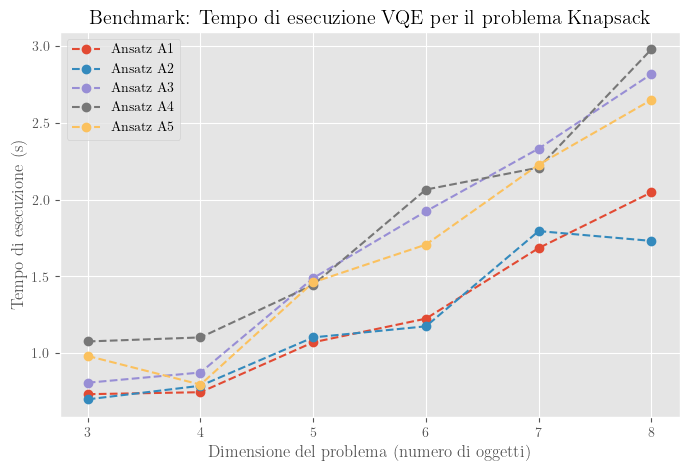

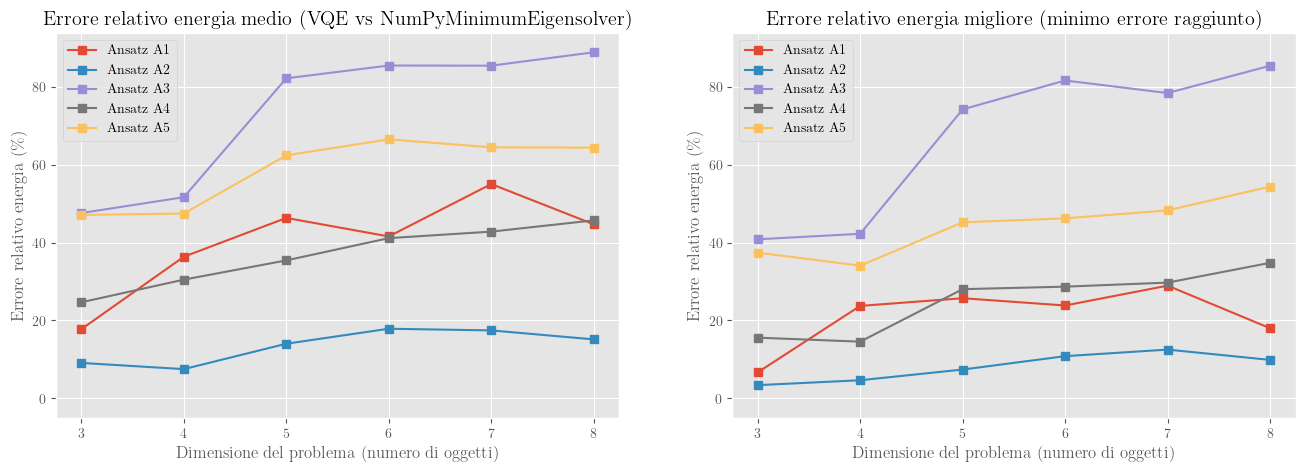

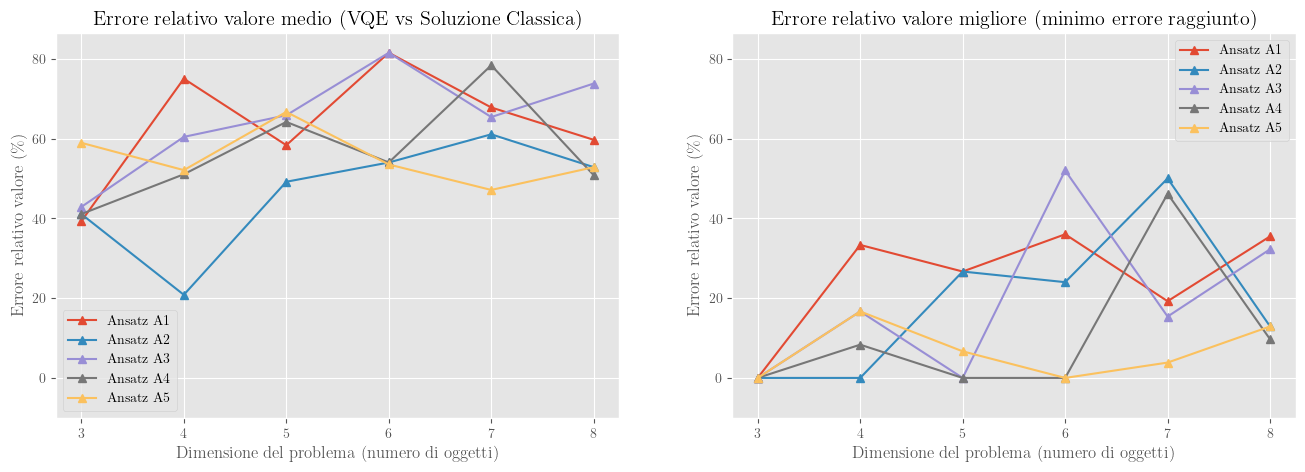

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Disabilita i warning per una visualizzazione più pulita
import warnings
warnings.filterwarnings('ignore')


# Importazioni per Qiskit Optimization e algoritmi quantistici
from qiskit_optimization.applications.knapsack import Knapsack
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_aer.primitives import Sampler
from qiskit_algorithms.utils import algorithm_globals


from matplotlib import rc

# Set del font a Computer Modern
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# ---------------------------
# Configurazione iniziale e seed
# ---------------------------
algorithm_globals.random_seed = 123
np.random.seed(123)  # Per la generazione casuale delle istanze

# Variabile per il numero di esecuzioni per istanza VQE
VQE_executions_per_instance = 8

# Parametri per la generazione delle istanze del KP
min_istanze = 3   # numero minimo di oggetti per istanza
max_istanze = 8   # numero massimo di oggetti per istanza

# ---------------------------
# Definizione di 5 diverse ansatz
# ---------------------------
def get_ansatz(ansatz_name, num_qubits):
    if ansatz_name == "A1":
        # Ansatz A1: usa solo 'rx', 2 rep, entanglement lineare
        return TwoLocal(num_qubits, ['rx'], 'cx', reps=2, entanglement='linear')
    elif ansatz_name == "A2":
        # Ansatz A2: usa solo 'ry', 2 rep, entanglement full
        return TwoLocal(num_qubits, ['ry'], 'cx', reps=2, entanglement='full')
    elif ansatz_name == "A3":
        # Ansatz A3: usa 'rx' e 'rz', 4 rep, entanglement circular
        return TwoLocal(num_qubits, ['rx', 'rz'], 'cx', reps=4, entanglement='circular')
    elif ansatz_name == "A4":
        # Ansatz A4: usa 'ry' e 'rz', 3 rep, entanglement full
        return TwoLocal(num_qubits, ['ry', 'rz'], 'cx', reps=3, entanglement='full')
    elif ansatz_name == "A5":
        # Ansatz A5: usa 'rx' e 'ry', 4 rep, entanglement circular
        return TwoLocal(num_qubits, ['rx', 'ry'], 'cz', reps=4, entanglement='circular')
    else:
        raise ValueError("Ansatz non riconosciuto")

# ---------------------------
# Generazione casuale delle istanze del Knapsack
# ---------------------------
knapsack_instances = {}
print("Istanze del Knapsack generate:")
for n in range(min_istanze, max_istanze + 1):
    values = np.random.randint(1, 11, size=n).tolist()   # valori casuali da 1 a 10
    weights = np.random.randint(1, 6, size=n).tolist()     # pesi casuali da 1 a 5
    capacity = int(sum(weights) / 2)
    if capacity == 0:
        capacity = 1
    knapsack_instances[n] = (values, weights, capacity)
    print(f"Numero oggetti: {n} -> Valori: {values}, Pesi: {weights}, Capacità: {capacity}")

# ---------------------------
# Funzione per risolvere un'istanza del Knapsack con VQE
# ---------------------------
def solve_knapsack_instance_VQE(values, weights, capacity, ansatz_name):
    # 1. Creazione del modello: costruzione del problema KP
    knapsack_app = Knapsack(values, weights, capacity)
    qp = knapsack_app.to_quadratic_program()
    
    # 2. Conversione in QUBO e in problema Ising
    qubo_converter = QuadraticProgramToQubo()
    qubo = qubo_converter.convert(qp)
    qubit_op, offset = qubo.to_ising()
    
    # 3. Definizione dell'ansatz in base al tipo scelto
    ansatz = get_ansatz(ansatz_name, qubit_op.num_qubits)
    
    # 4. Scelta dell'ottimizzatore (SPSA come esempio)
    optimizer = COBYLA(maxiter=100)
    
    # 5. Creazione del VQE classico-quantistico
    vqe = SamplingVQE(
        sampler=Sampler(),
        optimizer=optimizer,
        ansatz=ansatz
    )
    
    # Esecuzione della simulazione VQE
    start_time = time.time()
    result = vqe.compute_minimum_eigenvalue(qubit_op)
    elapsed_time = time.time() - start_time
    
    # Interpretazione della soluzione: mappatura della distribuzione
    binary_solution = knapsack_app.sample_most_likely(result.eigenstate)
    decision_vars = binary_solution[:len(values)]
    chosen_items = [i for i, bit in enumerate(decision_vars) if bit == 1]
    
    # Calcolo del valore e del peso totale degli oggetti selezionati
    total_value = sum(values[i] for i in chosen_items)
    total_weight = sum(weights[i] for i in chosen_items)
    
    return chosen_items, total_value, total_weight, result, elapsed_time, qubit_op, offset

# ---------------------------
# Funzione per risolvere il KP in modo classico (brute force)
# ---------------------------
def solve_knapsack_instance_classical(values, weights, capacity):
    n = len(values)
    best_value = -1
    best_weight = 0
    best_items = []
    for i in range(2**n):
        chosen = []
        tot_weight = 0
        tot_value = 0
        for j in range(n):
            if i & (1 << j):
                tot_weight += weights[j]
                tot_value += values[j]
                chosen.append(j)
        if tot_weight <= capacity and tot_value > best_value:
            best_value = tot_value
            best_weight = tot_weight
            best_items = chosen
    return best_items, best_weight, best_value

# ---------------------------
# Ciclo sperimentale per ciascuna ansatz sulle stesse istanze
# ---------------------------
ansatz_names = ["A1", "A2", "A3", "A4", "A5"]

# Inizializziamo dei dizionari per raccogliere le metriche per ogni ansatz
execution_times_dict = {a: {} for a in ansatz_names}
energy_error_dict    = {a: {} for a in ansatz_names}      # errore energia medio (%)
value_error_dict     = {a: {} for a in ansatz_names}      # errore valore medio (%)
# Nuovi dizionari per le metriche migliori (minori) tra le esecuzioni
energy_error_best_dict = {a: {} for a in ansatz_names}    # errore energia migliore (%)
value_error_best_dict  = {a: {} for a in ansatz_names}    # errore valore migliore (%)

# Istanza di NumPyMinimumEigensolver per confronto energia
np_solver = NumPyMinimumEigensolver()

for ansatz in ansatz_names:
    print(f"\n===== Esecuzione per l'Ansatz {ansatz} =====")
    for num_items in sorted(knapsack_instances.keys()):
        values, weights, capacity = knapsack_instances[num_items]
        print(f"\nEsecuzione VQE per il KP con {num_items} oggetti, Ansatz {ansatz}")
        
        # Risoluzione classica (brute force) una sola volta per l'istanza
        classical_items, classical_weight, classical_value = solve_knapsack_instance_classical(values, weights, capacity)
        n = len(values)
        classical_bitstring = [1 if i in classical_items else 0 for i in range(n)]
        
        # Liste per raccogliere le metriche da più esecuzioni VQE
        times_list = []
        energy_error_list = []
        value_error_list = []
        
        # Esecuzione multipla del VQE per l'istanza corrente
        for exec_num in range(VQE_executions_per_instance):
            print(f"\n--- Esecuzione VQE numero {exec_num+1}/{VQE_executions_per_instance} ---")
            chosen_items, total_value, total_weight, result, elapsed_time, qubit_op, offset = \
                solve_knapsack_instance_VQE(values, weights, capacity, ansatz)
            
            # Calcolo dell'energia con NumPyMinimumEigensolver per confronto
            np_result = np_solver.compute_minimum_eigenvalue(operator=qubit_op)
            energy_np = np_result.eigenvalue.real
            energy_vqe = result.eigenvalue.real
            rel_error_energy = abs(energy_vqe - energy_np) / abs(energy_np) if energy_np != 0 else np.inf
            
            # Se la soluzione del vqe viola i vincoli, imposto il valore totale a 0
            if total_weight > capacity:
                total_value = 0
            # Errore relativo sul valore (classico vs VQE)
            rel_error_value = abs(classical_value - total_value) / abs(classical_value) if classical_value != 0 else 0
            
            # Conversione in percentuali
            energy_error_percent = rel_error_energy * 100
            value_error_percent  = rel_error_value * 100
            
            # Aggiunta dei risultati alle liste
            times_list.append(elapsed_time)
            energy_error_list.append(energy_error_percent)
            value_error_list.append(value_error_percent)
        
        # Calcolo delle medie delle metriche per l'istanza corrente
        avg_time = np.mean(times_list)
        avg_energy_error = np.mean(energy_error_list)
        avg_value_error = np.mean(value_error_list)
        
        # Calcolo dei valori migliori (minori errori)
        best_energy_error = np.min(energy_error_list)
        best_value_error = np.min(value_error_list)
        
        # Salvataggio delle metriche medie e migliori per l'ansatz corrente e per il numero di oggetti
        execution_times_dict[ansatz][num_items] = avg_time
        energy_error_dict[ansatz][num_items] = avg_energy_error
        value_error_dict[ansatz][num_items] = avg_value_error
        energy_error_best_dict[ansatz][num_items] = best_energy_error
        value_error_best_dict[ansatz][num_items] = best_value_error

# ---------------------------
# Grafici comparativi per ciascuna metrica e per ciascuna ansatz
# ---------------------------
problem_sizes = sorted(knapsack_instances.keys())

plt.style.use('ggplot')

# Grafico 1: Tempo di esecuzione medio
plt.figure(figsize=(8, 5))
for ansatz in ansatz_names:
    times = [execution_times_dict[ansatz][n] for n in problem_sizes]
    plt.plot(problem_sizes, times, marker='o', linestyle='--', label=f"Ansatz {ansatz}")
plt.xlabel("Dimensione del problema (numero di oggetti)")
plt.ylabel("Tempo di esecuzione (s)")
plt.title("Benchmark: Tempo di esecuzione VQE per il problema Knapsack")
plt.legend()
plt.grid(True)
plt.show()

# Grafici 2 e 3: Errore relativo energia medio e migliore (affiancati)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
# Grafico 2: Errore relativo energia medio (%)
for ansatz in ansatz_names:
    errors_avg = [energy_error_dict[ansatz][n] for n in problem_sizes]
    axes[0].plot(problem_sizes, errors_avg, marker='s', linestyle='-', label=f"Ansatz {ansatz}")
axes[0].set_xlabel("Dimensione del problema (numero di oggetti)")
axes[0].set_ylabel("Errore relativo energia (\%)")
axes[0].set_title("Errore relativo energia medio (VQE vs NumPyMinimumEigensolver)")
axes[0].legend()
axes[0].grid(True)

# Grafico 3: Errore relativo energia migliore (%)
for ansatz in ansatz_names:
    errors_best = [energy_error_best_dict[ansatz][n] for n in problem_sizes]
    axes[1].plot(problem_sizes, errors_best, marker='s', linestyle='-', label=f"Ansatz {ansatz}")
axes[1].set_xlabel("Dimensione del problema (numero di oggetti)")
axes[1].set_ylabel("Errore relativo energia (\%)")
axes[1].set_title("Errore relativo energia migliore (minimo errore raggiunto)")
axes[1].legend()
axes[1].grid(True)

# Imposto lo stesso intervallo sull'asse y per entrambi i grafici
all_energy_errors = (
    [energy_error_dict[a][n] for a in ansatz_names for n in problem_sizes] +
    [energy_error_best_dict[a][n] for a in ansatz_names for n in problem_sizes]
)
max_energy_error = max(all_energy_errors)
min_energy_error = min(all_energy_errors)
axes[0].set_ylim(min(-5, min_energy_error), max_energy_error+5)
axes[1].set_ylim(min(-5, min_energy_error), max_energy_error+5)

plt.show()


# Grafici 4 e 5: Errore relativo valore medio e migliore (affiancati)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
# Grafico 4: Errore relativo valore medio (%)
for ansatz in ansatz_names:
    errors_avg = [value_error_dict[ansatz][n] for n in problem_sizes]
    axes[0].plot(problem_sizes, errors_avg, marker='^', linestyle='-', label=f"Ansatz {ansatz}")
axes[0].set_xlabel("Dimensione del problema (numero di oggetti)")
axes[0].set_ylabel("Errore relativo valore (\%)")
axes[0].set_title("Errore relativo valore medio (VQE vs Soluzione Classica)")
axes[0].legend()
axes[0].grid(True)

# Grafico 5: Errore relativo valore migliore (%)
for ansatz in ansatz_names:
    errors_best = [value_error_best_dict[ansatz][n] for n in problem_sizes]
    axes[1].plot(problem_sizes, errors_best, marker='^', linestyle='-', label=f"Ansatz {ansatz}")
axes[1].set_xlabel("Dimensione del problema (numero di oggetti)")
axes[1].set_ylabel("Errore relativo valore (\%)")
axes[1].set_title("Errore relativo valore migliore (minimo errore raggiunto)")
axes[1].legend()
axes[1].grid(True)

# Imposto lo stesso intervallo sull'asse y per entrambi i grafici
all_value_errors = (
    [value_error_dict[a][n] for a in ansatz_names for n in problem_sizes] +
    [value_error_best_dict[a][n] for a in ansatz_names for n in problem_sizes]
)
max_value_error = max(all_value_errors)
min_value_error = min(all_value_errors)
axes[0].set_ylim(min(-5, min_value_error-10), max_value_error+5)
axes[1].set_ylim(min(-5, min_value_error-10), max_value_error+5)

plt.show()


Istanze del Knapsack generate:
Numero oggetti: 3 -> Valori: [3, 3, 7], Pesi: [2, 4, 3], Capacità: 4
Numero oggetti: 4 -> Valori: [10, 7, 2, 1], Pesi: [2, 2, 1, 1], Capacità: 3
Numero oggetti: 5 -> Valori: [10, 4, 5, 1, 1], Pesi: [5, 2, 4, 3, 5], Capacità: 9
Numero oggetti: 6 -> Valori: [8, 3, 5, 9, 1, 8], Pesi: [2, 4, 5, 5, 5, 2], Capacità: 11
Numero oggetti: 7 -> Valori: [6, 7, 3, 2, 9, 4, 6], Pesi: [1, 4, 3, 3, 3, 3, 5], Capacità: 11
Numero oggetti: 8 -> Valori: [5, 7, 4, 1, 7, 5, 8, 7], Pesi: [2, 4, 3, 2, 3, 5, 1, 2], Capacità: 11

===== Esecuzione per l'Ansatz A1 =====

Esecuzione VQE per il KP con 3 oggetti, Ansatz A1

--- Esecuzione VQE numero 1/3 ---

--- Esecuzione VQE numero 2/3 ---

--- Esecuzione VQE numero 3/3 ---

Esecuzione VQE per il KP con 4 oggetti, Ansatz A1

--- Esecuzione VQE numero 1/3 ---

--- Esecuzione VQE numero 2/3 ---

--- Esecuzione VQE numero 3/3 ---

Esecuzione VQE per il KP con 5 oggetti, Ansatz A1

--- Esecuzione VQE numero 1/3 ---

--- Esecuzione VQE nu

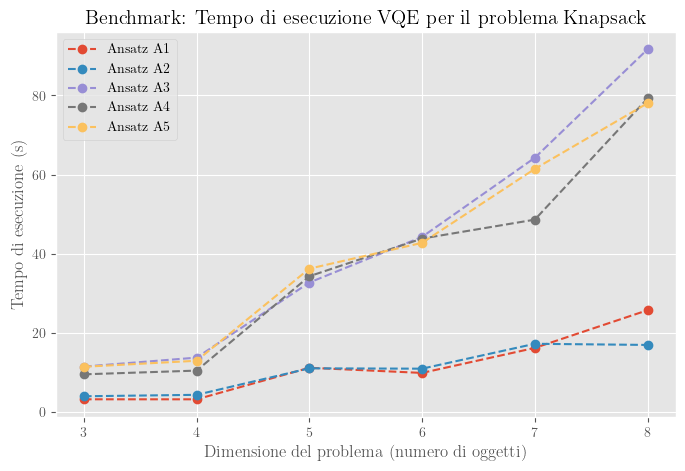

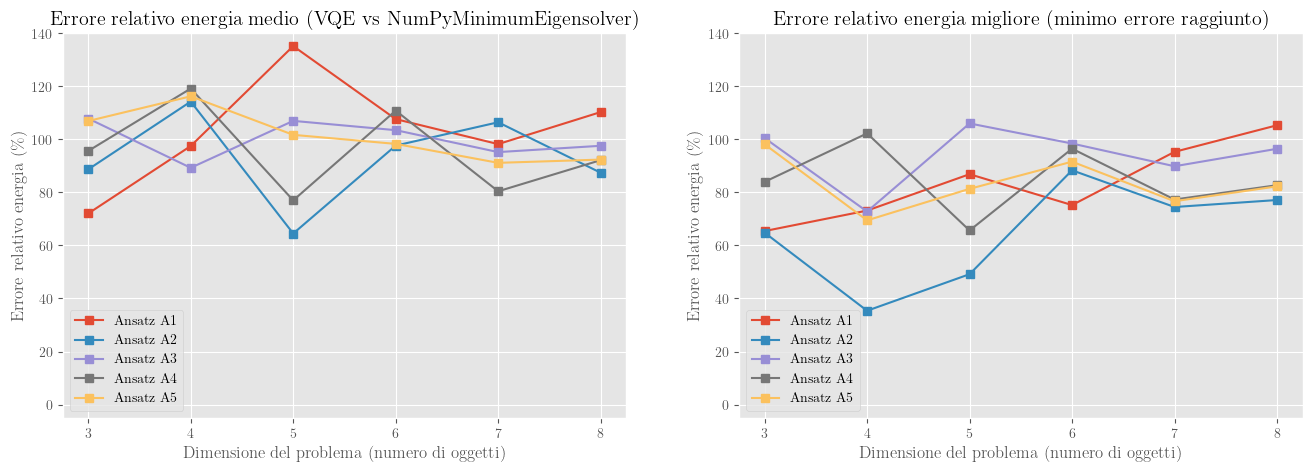

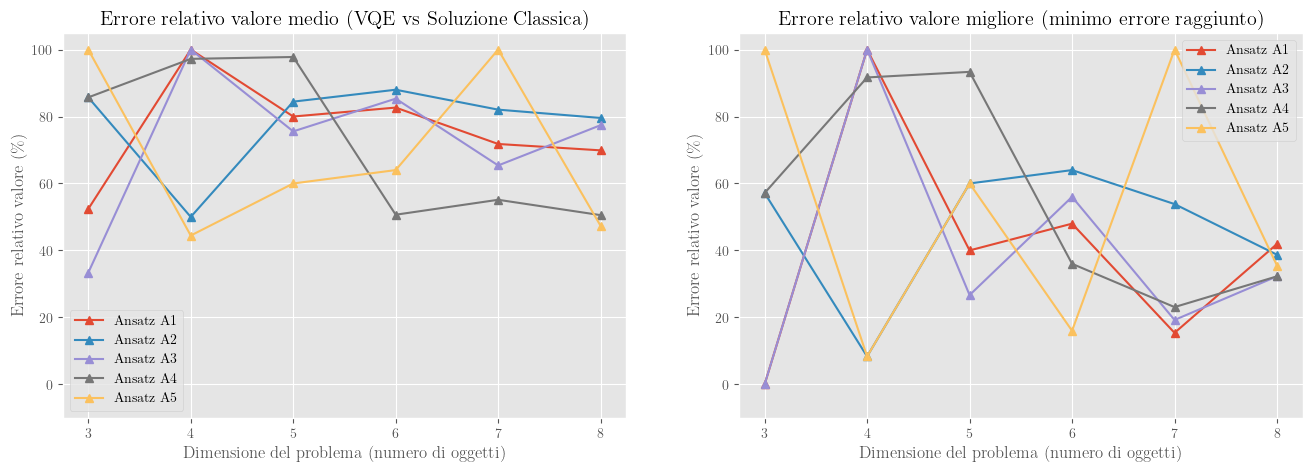

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Disabilita i warning per una visualizzazione più pulita
import warnings
warnings.filterwarnings('ignore')


# Importazioni per Qiskit Optimization e algoritmi quantistici
from qiskit_optimization.applications.knapsack import Knapsack
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import L_BFGS_B
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_aer.primitives import Sampler
from qiskit_algorithms.utils import algorithm_globals


from matplotlib import rc

# Set del font a Computer Modern
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# ---------------------------
# Configurazione iniziale e seed
# ---------------------------
algorithm_globals.random_seed = 123
np.random.seed(123)  # Per la generazione casuale delle istanze

# Variabile per il numero di esecuzioni per istanza VQE
VQE_executions_per_instance = 3 

# Parametri per la generazione delle istanze del KP
min_istanze = 3   # numero minimo di oggetti per istanza
max_istanze = 8   # numero massimo di oggetti per istanza

# ---------------------------
# Definizione di 5 diverse ansatz
# ---------------------------
def get_ansatz(ansatz_name, num_qubits):
    if ansatz_name == "A1":
        # Ansatz A1: usa solo 'rx', 2 rep, entanglement lineare
        return TwoLocal(num_qubits, ['rx'], 'cx', reps=2, entanglement='linear')
    elif ansatz_name == "A2":
        # Ansatz A2: usa solo 'ry', 2 rep, entanglement full
        return TwoLocal(num_qubits, ['ry'], 'cx', reps=2, entanglement='full')
    elif ansatz_name == "A3":
        # Ansatz A3: usa 'rx' e 'rz', 4 rep, entanglement circular
        return TwoLocal(num_qubits, ['rx', 'rz'], 'cx', reps=4, entanglement='circular')
    elif ansatz_name == "A4":
        # Ansatz A4: usa 'ry' e 'rz', 3 rep, entanglement full
        return TwoLocal(num_qubits, ['ry', 'rz'], 'cx', reps=3, entanglement='full')
    elif ansatz_name == "A5":
        # Ansatz A5: usa 'rx' e 'ry', 4 rep, entanglement circular
        return TwoLocal(num_qubits, ['rx', 'ry'], 'cz', reps=4, entanglement='circular')
    else:
        raise ValueError("Ansatz non riconosciuto")

# ---------------------------
# Generazione casuale delle istanze del Knapsack
# ---------------------------
knapsack_instances = {}
print("Istanze del Knapsack generate:")
for n in range(min_istanze, max_istanze + 1):
    values = np.random.randint(1, 11, size=n).tolist()   # valori casuali da 1 a 10
    weights = np.random.randint(1, 6, size=n).tolist()     # pesi casuali da 1 a 5
    capacity = int(sum(weights) / 2)
    if capacity == 0:
        capacity = 1
    knapsack_instances[n] = (values, weights, capacity)
    print(f"Numero oggetti: {n} -> Valori: {values}, Pesi: {weights}, Capacità: {capacity}")

# ---------------------------
# Funzione per risolvere un'istanza del Knapsack con VQE
# ---------------------------
def solve_knapsack_instance_VQE(values, weights, capacity, ansatz_name):
    # 1. Creazione del modello: costruzione del problema KP
    knapsack_app = Knapsack(values, weights, capacity)
    qp = knapsack_app.to_quadratic_program()
    
    # 2. Conversione in QUBO e in problema Ising
    qubo_converter = QuadraticProgramToQubo()
    qubo = qubo_converter.convert(qp)
    qubit_op, offset = qubo.to_ising()
    
    # 3. Definizione dell'ansatz in base al tipo scelto
    ansatz = get_ansatz(ansatz_name, qubit_op.num_qubits)
    
    # 4. Scelta dell'ottimizzatore
    optimizer = L_BFGS_B()
    
    # 5. Creazione del VQE classico-quantistico
    vqe = SamplingVQE(
        sampler=Sampler(),
        optimizer=optimizer,
        ansatz=ansatz
    )
    
    # Esecuzione della simulazione VQE
    start_time = time.time()
    result = vqe.compute_minimum_eigenvalue(qubit_op)
    elapsed_time = time.time() - start_time
    
    # Interpretazione della soluzione: mappatura della distribuzione
    binary_solution = knapsack_app.sample_most_likely(result.eigenstate)
    decision_vars = binary_solution[:len(values)]
    chosen_items = [i for i, bit in enumerate(decision_vars) if bit == 1]
    
    # Calcolo del valore e del peso totale degli oggetti selezionati
    total_value = sum(values[i] for i in chosen_items)
    total_weight = sum(weights[i] for i in chosen_items)
    
    return chosen_items, total_value, total_weight, result, elapsed_time, qubit_op, offset

# ---------------------------
# Funzione per risolvere il KP in modo classico (brute force)
# ---------------------------
def solve_knapsack_instance_classical(values, weights, capacity):
    n = len(values)
    best_value = -1
    best_weight = 0
    best_items = []
    for i in range(2**n):
        chosen = []
        tot_weight = 0
        tot_value = 0
        for j in range(n):
            if i & (1 << j):
                tot_weight += weights[j]
                tot_value += values[j]
                chosen.append(j)
        if tot_weight <= capacity and tot_value > best_value:
            best_value = tot_value
            best_weight = tot_weight
            best_items = chosen
    return best_items, best_weight, best_value

# ---------------------------
# Ciclo sperimentale per ciascuna ansatz sulle stesse istanze
# ---------------------------
ansatz_names = ["A1", "A2", "A3", "A4", "A5"]

# Inizializziamo dei dizionari per raccogliere le metriche per ogni ansatz
execution_times_dict = {a: {} for a in ansatz_names}
energy_error_dict    = {a: {} for a in ansatz_names}      # errore energia medio (%)
value_error_dict     = {a: {} for a in ansatz_names}      # errore valore medio (%)
# Nuovi dizionari per le metriche migliori (minori) tra le esecuzioni
energy_error_best_dict = {a: {} for a in ansatz_names}    # errore energia migliore (%)
value_error_best_dict  = {a: {} for a in ansatz_names}    # errore valore migliore (%)

# Istanza di NumPyMinimumEigensolver per confronto energia
np_solver = NumPyMinimumEigensolver()

for ansatz in ansatz_names:
    print(f"\n===== Esecuzione per l'Ansatz {ansatz} =====")
    for num_items in sorted(knapsack_instances.keys()):
        values, weights, capacity = knapsack_instances[num_items]
        print(f"\nEsecuzione VQE per il KP con {num_items} oggetti, Ansatz {ansatz}")
        
        # Risoluzione classica (brute force) una sola volta per l'istanza
        classical_items, classical_weight, classical_value = solve_knapsack_instance_classical(values, weights, capacity)
        n = len(values)
        classical_bitstring = [1 if i in classical_items else 0 for i in range(n)]
        
        # Liste per raccogliere le metriche da più esecuzioni VQE
        times_list = []
        energy_error_list = []
        value_error_list = []
        
        # Esecuzione multipla del VQE per l'istanza corrente
        for exec_num in range(VQE_executions_per_instance):
            print(f"\n--- Esecuzione VQE numero {exec_num+1}/{VQE_executions_per_instance} ---")
            chosen_items, total_value, total_weight, result, elapsed_time, qubit_op, offset = \
                solve_knapsack_instance_VQE(values, weights, capacity, ansatz)
            
            # Calcolo dell'energia con NumPyMinimumEigensolver per confronto
            np_result = np_solver.compute_minimum_eigenvalue(operator=qubit_op)
            energy_np = np_result.eigenvalue.real
            energy_vqe = result.eigenvalue.real
            rel_error_energy = abs(energy_vqe - energy_np) / abs(energy_np) if energy_np != 0 else np.inf
            
            # Se la soluzione del vqe viola i vincoli, imposto il valore totale a 0
            if total_weight > capacity:
                total_value = 0
            
            # Errore relativo sul valore (classico vs VQE)
            rel_error_value = abs(classical_value - total_value) / abs(classical_value) if classical_value != 0 else 0
            
            # Conversione in percentuali
            energy_error_percent = rel_error_energy * 100
            value_error_percent  = rel_error_value * 100
            
            # Aggiunta dei risultati alle liste
            times_list.append(elapsed_time)
            energy_error_list.append(energy_error_percent)
            value_error_list.append(value_error_percent)
        
        # Calcolo delle medie delle metriche per l'istanza corrente
        avg_time = np.mean(times_list)
        avg_energy_error = np.mean(energy_error_list)
        avg_value_error = np.mean(value_error_list)
        
        # Calcolo dei valori migliori (minori errori)
        best_energy_error = np.min(energy_error_list)
        best_value_error = np.min(value_error_list)
        
        # Salvataggio delle metriche medie e migliori per l'ansatz corrente e per il numero di oggetti
        execution_times_dict[ansatz][num_items] = avg_time
        energy_error_dict[ansatz][num_items] = avg_energy_error
        value_error_dict[ansatz][num_items] = avg_value_error
        energy_error_best_dict[ansatz][num_items] = best_energy_error
        value_error_best_dict[ansatz][num_items] = best_value_error

# ---------------------------
# Grafici comparativi per ciascuna metrica e per ciascuna ansatz
# ---------------------------
problem_sizes = sorted(knapsack_instances.keys())

plt.style.use('ggplot')

# Grafico 1: Tempo di esecuzione medio
plt.figure(figsize=(8, 5))
for ansatz in ansatz_names:
    times = [execution_times_dict[ansatz][n] for n in problem_sizes]
    plt.plot(problem_sizes, times, marker='o', linestyle='--', label=f"Ansatz {ansatz}")
plt.xlabel("Dimensione del problema (numero di oggetti)")
plt.ylabel("Tempo di esecuzione (s)")
plt.title("Benchmark: Tempo di esecuzione VQE per il problema Knapsack")
plt.legend()
plt.grid(True)
plt.show()

# Grafici 2 e 3: Errore relativo energia medio e migliore (affiancati)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
# Grafico 2: Errore relativo energia medio (%)
for ansatz in ansatz_names:
    errors_avg = [energy_error_dict[ansatz][n] for n in problem_sizes]
    axes[0].plot(problem_sizes, errors_avg, marker='s', linestyle='-', label=f"Ansatz {ansatz}")
axes[0].set_xlabel("Dimensione del problema (numero di oggetti)")
axes[0].set_ylabel("Errore relativo energia (\%)")
axes[0].set_title("Errore relativo energia medio (VQE vs NumPyMinimumEigensolver)")
axes[0].legend()
axes[0].grid(True)

# Grafico 3: Errore relativo energia migliore (%)
for ansatz in ansatz_names:
    errors_best = [energy_error_best_dict[ansatz][n] for n in problem_sizes]
    axes[1].plot(problem_sizes, errors_best, marker='s', linestyle='-', label=f"Ansatz {ansatz}")
axes[1].set_xlabel("Dimensione del problema (numero di oggetti)")
axes[1].set_ylabel("Errore relativo energia (\%)")
axes[1].set_title("Errore relativo energia migliore (minimo errore raggiunto)")
axes[1].legend()
axes[1].grid(True)

# Imposto lo stesso intervallo sull'asse y per entrambi i grafici
all_energy_errors = (
    [energy_error_dict[a][n] for a in ansatz_names for n in problem_sizes] +
    [energy_error_best_dict[a][n] for a in ansatz_names for n in problem_sizes]
)
max_energy_error = max(all_energy_errors)
min_energy_error = min(all_energy_errors)
axes[0].set_ylim(min(-5, min_energy_error), max_energy_error+5)
axes[1].set_ylim(min(-5, min_energy_error), max_energy_error+5)

plt.show()


# Grafici 4 e 5: Errore relativo valore medio e migliore (affiancati)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
# Grafico 4: Errore relativo valore medio (%)
for ansatz in ansatz_names:
    errors_avg = [value_error_dict[ansatz][n] for n in problem_sizes]
    axes[0].plot(problem_sizes, errors_avg, marker='^', linestyle='-', label=f"Ansatz {ansatz}")
axes[0].set_xlabel("Dimensione del problema (numero di oggetti)")
axes[0].set_ylabel("Errore relativo valore (\%)")
axes[0].set_title("Errore relativo valore medio (VQE vs Soluzione Classica)")
axes[0].legend()
axes[0].grid(True)

# Grafico 5: Errore relativo valore migliore (%)
for ansatz in ansatz_names:
    errors_best = [value_error_best_dict[ansatz][n] for n in problem_sizes]
    axes[1].plot(problem_sizes, errors_best, marker='^', linestyle='-', label=f"Ansatz {ansatz}")
axes[1].set_xlabel("Dimensione del problema (numero di oggetti)")
axes[1].set_ylabel("Errore relativo valore (\%)")
axes[1].set_title("Errore relativo valore migliore (minimo errore raggiunto)")
axes[1].legend()
axes[1].grid(True)

# Imposto lo stesso intervallo sull'asse y per entrambi i grafici
all_value_errors = (
    [value_error_dict[a][n] for a in ansatz_names for n in problem_sizes] +
    [value_error_best_dict[a][n] for a in ansatz_names for n in problem_sizes]
)
max_value_error = max(all_value_errors)
min_value_error = min(all_value_errors)
axes[0].set_ylim(min(-5, min_value_error-10), max_value_error+5)
axes[1].set_ylim(min(-5, min_value_error-10), max_value_error+5)

plt.show()


Istanze del Knapsack generate:
Numero oggetti: 3 -> Valori: [3, 3, 7], Pesi: [2, 4, 3], Capacità: 4
Numero oggetti: 4 -> Valori: [10, 7, 2, 1], Pesi: [2, 2, 1, 1], Capacità: 3
Numero oggetti: 5 -> Valori: [10, 4, 5, 1, 1], Pesi: [5, 2, 4, 3, 5], Capacità: 9
Numero oggetti: 6 -> Valori: [8, 3, 5, 9, 1, 8], Pesi: [2, 4, 5, 5, 5, 2], Capacità: 11
Numero oggetti: 7 -> Valori: [6, 7, 3, 2, 9, 4, 6], Pesi: [1, 4, 3, 3, 3, 3, 5], Capacità: 11
Numero oggetti: 8 -> Valori: [5, 7, 4, 1, 7, 5, 8, 7], Pesi: [2, 4, 3, 2, 3, 5, 1, 2], Capacità: 11

===== Esecuzione per l'Ansatz A6 =====

Esecuzione VQE per il KP con 3 oggetti, Ansatz A6

--- Esecuzione VQE numero 1/8 ---

--- Esecuzione VQE numero 2/8 ---

--- Esecuzione VQE numero 3/8 ---

--- Esecuzione VQE numero 4/8 ---

--- Esecuzione VQE numero 5/8 ---

--- Esecuzione VQE numero 6/8 ---

--- Esecuzione VQE numero 7/8 ---

--- Esecuzione VQE numero 8/8 ---

Esecuzione VQE per il KP con 4 oggetti, Ansatz A6

--- Esecuzione VQE numero 1/8 ---

--

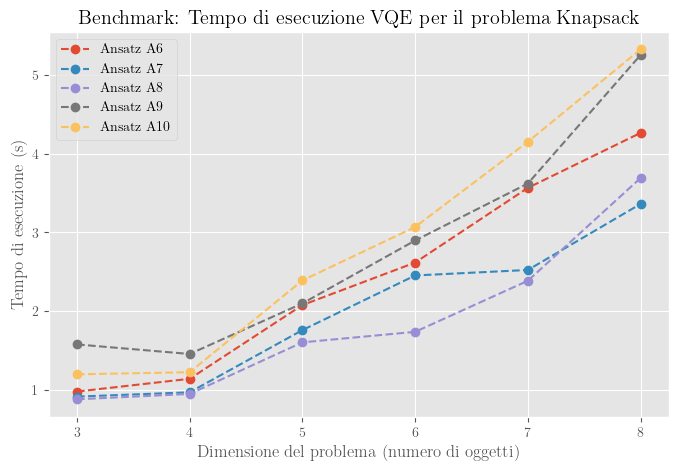

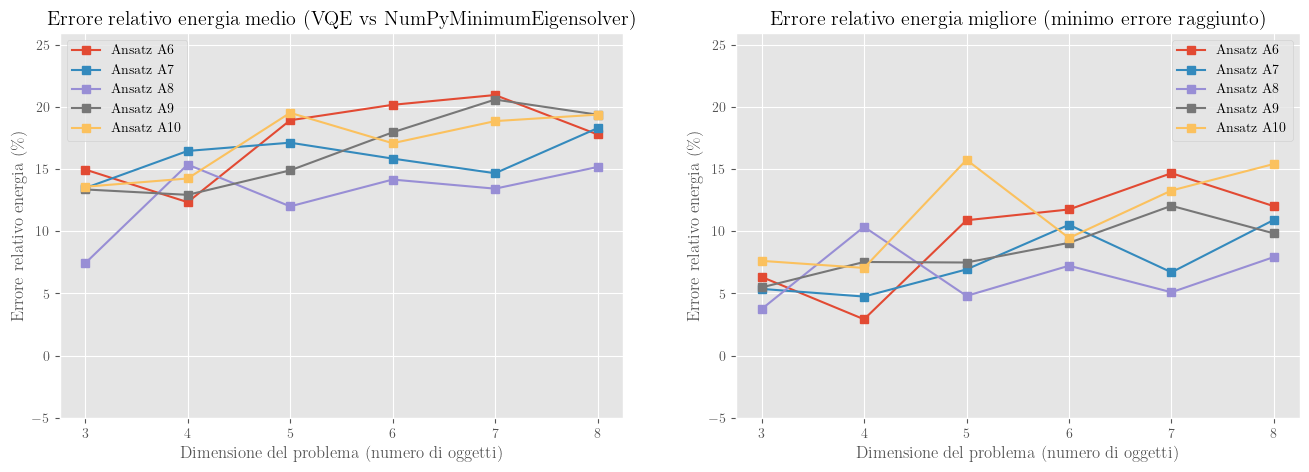

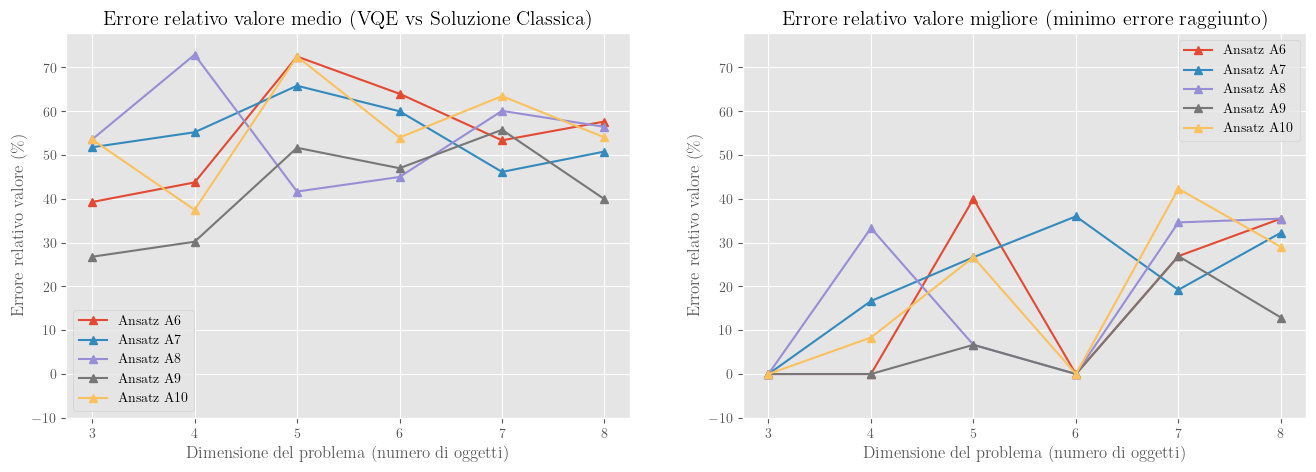

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Disabilita i warning per una visualizzazione più pulita
import warnings
warnings.filterwarnings('ignore')


# Importazioni per Qiskit Optimization e algoritmi quantistici
from qiskit_optimization.applications.knapsack import Knapsack
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_aer.primitives import Sampler
from qiskit_algorithms.utils import algorithm_globals


from matplotlib import rc

# Set del font a Computer Modern
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# ---------------------------
# Configurazione iniziale e seed
# ---------------------------
algorithm_globals.random_seed = 123
np.random.seed(123)  # Per la generazione casuale delle istanze

# Variabile per il numero di esecuzioni per istanza VQE
VQE_executions_per_instance = 8

# Parametri per la generazione delle istanze del KP
min_istanze = 3   # numero minimo di oggetti per istanza
max_istanze = 8   # numero massimo di oggetti per istanza

# ---------------------------
# Definizione di 5 diverse ansatz
# ---------------------------
def get_ansatz(ansatz_name, num_qubits):
    if ansatz_name == "A6":
        return TwoLocal(num_qubits, ['rx'], 'cx', reps=2, entanglement='full')
    elif ansatz_name == "A7":
        return TwoLocal(num_qubits, ['rx', 'rz'], 'cx', reps=1, entanglement='full')
    elif ansatz_name == "A8":
        return TwoLocal(num_qubits, ['rx', 'rz'], 'cz', reps=1, entanglement='full')
    elif ansatz_name == "A9":
        return TwoLocal(num_qubits, ['rx', 'ry'], 'cx', reps=2, entanglement='full')
    elif ansatz_name == "A10":
        return TwoLocal(num_qubits, ['ry', 'rz'], 'cz', reps=3, entanglement='full')
    else:
        raise ValueError("Ansatz non riconosciuto")

# ---------------------------
# Generazione casuale delle istanze del Knapsack
# ---------------------------
knapsack_instances = {}
print("Istanze del Knapsack generate:")
for n in range(min_istanze, max_istanze + 1):
    values = np.random.randint(1, 11, size=n).tolist()   # valori casuali da 1 a 10
    weights = np.random.randint(1, 6, size=n).tolist()     # pesi casuali da 1 a 5
    capacity = int(sum(weights) / 2)
    if capacity == 0:
        capacity = 1
    knapsack_instances[n] = (values, weights, capacity)
    print(f"Numero oggetti: {n} -> Valori: {values}, Pesi: {weights}, Capacità: {capacity}")

# ---------------------------
# Funzione per risolvere un'istanza del Knapsack con VQE
# ---------------------------
def solve_knapsack_instance_VQE(values, weights, capacity, ansatz_name):
    # 1. Creazione del modello: costruzione del problema KP
    knapsack_app = Knapsack(values, weights, capacity)
    qp = knapsack_app.to_quadratic_program()
    
    # 2. Conversione in QUBO e in problema Ising
    qubo_converter = QuadraticProgramToQubo()
    qubo = qubo_converter.convert(qp)
    qubit_op, offset = qubo.to_ising()
    
    # 3. Definizione dell'ansatz in base al tipo scelto
    ansatz = get_ansatz(ansatz_name, qubit_op.num_qubits)
    
    # 4. Scelta dell'ottimizzatore (SPSA come esempio)
    optimizer = SPSA(maxiter=100)
    
    # 5. Creazione del VQE classico-quantistico
    vqe = SamplingVQE(
        sampler=Sampler(),
        optimizer=optimizer,
        ansatz=ansatz
    )
    
    # Esecuzione della simulazione VQE
    start_time = time.time()
    result = vqe.compute_minimum_eigenvalue(qubit_op)
    elapsed_time = time.time() - start_time
    
    # Interpretazione della soluzione: mappatura della distribuzione
    binary_solution = knapsack_app.sample_most_likely(result.eigenstate)
    decision_vars = binary_solution[:len(values)]
    chosen_items = [i for i, bit in enumerate(decision_vars) if bit == 1]
    
    # Calcolo del valore e del peso totale degli oggetti selezionati
    total_value = sum(values[i] for i in chosen_items)
    total_weight = sum(weights[i] for i in chosen_items)
    
    return chosen_items, total_value, total_weight, result, elapsed_time, qubit_op, offset

# ---------------------------
# Funzione per risolvere il KP in modo classico (brute force)
# ---------------------------
def solve_knapsack_instance_classical(values, weights, capacity):
    n = len(values)
    best_value = -1
    best_weight = 0
    best_items = []
    for i in range(2**n):
        chosen = []
        tot_weight = 0
        tot_value = 0
        for j in range(n):
            if i & (1 << j):
                tot_weight += weights[j]
                tot_value += values[j]
                chosen.append(j)
        if tot_weight <= capacity and tot_value > best_value:
            best_value = tot_value
            best_weight = tot_weight
            best_items = chosen
    return best_items, best_weight, best_value

# ---------------------------
# Ciclo sperimentale per ciascuna ansatz sulle stesse istanze
# ---------------------------
ansatz_names = ["A6", "A7", "A8", "A9", "A10"]

# Inizializziamo dei dizionari per raccogliere le metriche per ogni ansatz
execution_times_dict = {a: {} for a in ansatz_names}
energy_error_dict    = {a: {} for a in ansatz_names}      # errore energia medio (%)
value_error_dict     = {a: {} for a in ansatz_names}      # errore valore medio (%)
# Nuovi dizionari per le metriche migliori (minori) tra le esecuzioni
energy_error_best_dict = {a: {} for a in ansatz_names}    # errore energia migliore (%)
value_error_best_dict  = {a: {} for a in ansatz_names}    # errore valore migliore (%)

# Istanza di NumPyMinimumEigensolver per confronto energia
np_solver = NumPyMinimumEigensolver()

for ansatz in ansatz_names:
    print(f"\n===== Esecuzione per l'Ansatz {ansatz} =====")
    for num_items in sorted(knapsack_instances.keys()):
        values, weights, capacity = knapsack_instances[num_items]
        print(f"\nEsecuzione VQE per il KP con {num_items} oggetti, Ansatz {ansatz}")
        
        # Risoluzione classica (brute force) una sola volta per l'istanza
        classical_items, classical_weight, classical_value = solve_knapsack_instance_classical(values, weights, capacity)
        n = len(values)
        classical_bitstring = [1 if i in classical_items else 0 for i in range(n)]
        
        # Liste per raccogliere le metriche da più esecuzioni VQE
        times_list = []
        energy_error_list = []
        value_error_list = []
        
        # Esecuzione multipla del VQE per l'istanza corrente
        for exec_num in range(VQE_executions_per_instance):
            print(f"\n--- Esecuzione VQE numero {exec_num+1}/{VQE_executions_per_instance} ---")
            chosen_items, total_value, total_weight, result, elapsed_time, qubit_op, offset = \
                solve_knapsack_instance_VQE(values, weights, capacity, ansatz)
            
            # Calcolo dell'energia con NumPyMinimumEigensolver per confronto
            np_result = np_solver.compute_minimum_eigenvalue(operator=qubit_op)
            energy_np = np_result.eigenvalue.real
            energy_vqe = result.eigenvalue.real
            rel_error_energy = abs(energy_vqe - energy_np) / abs(energy_np) if energy_np != 0 else np.inf
            
            # Se la soluzione del vqe viola i vincoli, imposto il valore totale a 0
            if total_weight > capacity:
                total_value = 0
            
            # Errore relativo sul valore (classico vs VQE)
            rel_error_value = abs(classical_value - total_value) / abs(classical_value) if classical_value != 0 else 0
            
            # Conversione in percentuali
            energy_error_percent = rel_error_energy * 100
            value_error_percent  = rel_error_value * 100
            
            # Aggiunta dei risultati alle liste
            times_list.append(elapsed_time)
            energy_error_list.append(energy_error_percent)
            value_error_list.append(value_error_percent)
        
        # Calcolo delle medie delle metriche per l'istanza corrente
        avg_time = np.mean(times_list)
        avg_energy_error = np.mean(energy_error_list)
        avg_value_error = np.mean(value_error_list)
        
        # Calcolo dei valori migliori (minori errori)
        best_energy_error = np.min(energy_error_list)
        best_value_error = np.min(value_error_list)
        
        # Salvataggio delle metriche medie e migliori per l'ansatz corrente e per il numero di oggetti
        execution_times_dict[ansatz][num_items] = avg_time
        energy_error_dict[ansatz][num_items] = avg_energy_error
        value_error_dict[ansatz][num_items] = avg_value_error
        energy_error_best_dict[ansatz][num_items] = best_energy_error
        value_error_best_dict[ansatz][num_items] = best_value_error

# ---------------------------
# Grafici comparativi per ciascuna metrica e per ciascuna ansatz
# ---------------------------
problem_sizes = sorted(knapsack_instances.keys())

plt.style.use('ggplot')

# Grafico 1: Tempo di esecuzione medio
plt.figure(figsize=(8, 5))
for ansatz in ansatz_names:
    times = [execution_times_dict[ansatz][n] for n in problem_sizes]
    plt.plot(problem_sizes, times, marker='o', linestyle='--', label=f"Ansatz {ansatz}")
plt.xlabel("Dimensione del problema (numero di oggetti)")
plt.ylabel("Tempo di esecuzione (s)")
plt.title("Benchmark: Tempo di esecuzione VQE per il problema Knapsack")
plt.legend()
plt.grid(True)
plt.show()

# Grafici 2 e 3: Errore relativo energia medio e migliore (affiancati)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
# Grafico 2: Errore relativo energia medio (%)
for ansatz in ansatz_names:
    errors_avg = [energy_error_dict[ansatz][n] for n in problem_sizes]
    axes[0].plot(problem_sizes, errors_avg, marker='s', linestyle='-', label=f"Ansatz {ansatz}")
axes[0].set_xlabel("Dimensione del problema (numero di oggetti)")
axes[0].set_ylabel("Errore relativo energia (\%)")
axes[0].set_title("Errore relativo energia medio (VQE vs NumPyMinimumEigensolver)")
axes[0].legend()
axes[0].grid(True)

# Grafico 3: Errore relativo energia migliore (%)
for ansatz in ansatz_names:
    errors_best = [energy_error_best_dict[ansatz][n] for n in problem_sizes]
    axes[1].plot(problem_sizes, errors_best, marker='s', linestyle='-', label=f"Ansatz {ansatz}")
axes[1].set_xlabel("Dimensione del problema (numero di oggetti)")
axes[1].set_ylabel("Errore relativo energia (\%)")
axes[1].set_title("Errore relativo energia migliore (minimo errore raggiunto)")
axes[1].legend()
axes[1].grid(True)

# Imposto lo stesso intervallo sull'asse y per entrambi i grafici
all_energy_errors = (
    [energy_error_dict[a][n] for a in ansatz_names for n in problem_sizes] +
    [energy_error_best_dict[a][n] for a in ansatz_names for n in problem_sizes]
)
max_energy_error = max(all_energy_errors)
min_energy_error = min(all_energy_errors)
axes[0].set_ylim(min(-5, min_energy_error), max_energy_error+5)
axes[1].set_ylim(min(-5, min_energy_error), max_energy_error+5)

plt.show()


# Grafici 4 e 5: Errore relativo valore medio e migliore (affiancati)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
# Grafico 4: Errore relativo valore medio (%)
for ansatz in ansatz_names:
    errors_avg = [value_error_dict[ansatz][n] for n in problem_sizes]
    axes[0].plot(problem_sizes, errors_avg, marker='^', linestyle='-', label=f"Ansatz {ansatz}")
axes[0].set_xlabel("Dimensione del problema (numero di oggetti)")
axes[0].set_ylabel("Errore relativo valore (\%)")
axes[0].set_title("Errore relativo valore medio (VQE vs Soluzione Classica)")
axes[0].legend()
axes[0].grid(True)

# Grafico 5: Errore relativo valore migliore (%)
for ansatz in ansatz_names:
    errors_best = [value_error_best_dict[ansatz][n] for n in problem_sizes]
    axes[1].plot(problem_sizes, errors_best, marker='^', linestyle='-', label=f"Ansatz {ansatz}")
axes[1].set_xlabel("Dimensione del problema (numero di oggetti)")
axes[1].set_ylabel("Errore relativo valore (\%)")
axes[1].set_title("Errore relativo valore migliore (minimo errore raggiunto)")
axes[1].legend()
axes[1].grid(True)

# Imposto lo stesso intervallo sull'asse y per entrambi i grafici
all_value_errors = (
    [value_error_dict[a][n] for a in ansatz_names for n in problem_sizes] +
    [value_error_best_dict[a][n] for a in ansatz_names for n in problem_sizes]
)
max_value_error = max(all_value_errors)
min_value_error = min(all_value_errors)
axes[0].set_ylim(min(-5, min_value_error-10), max_value_error+5)
axes[1].set_ylim(min(-5, min_value_error-10), max_value_error+5)

plt.show()

Miglior ansatz (in termini di errore energia medio): A8


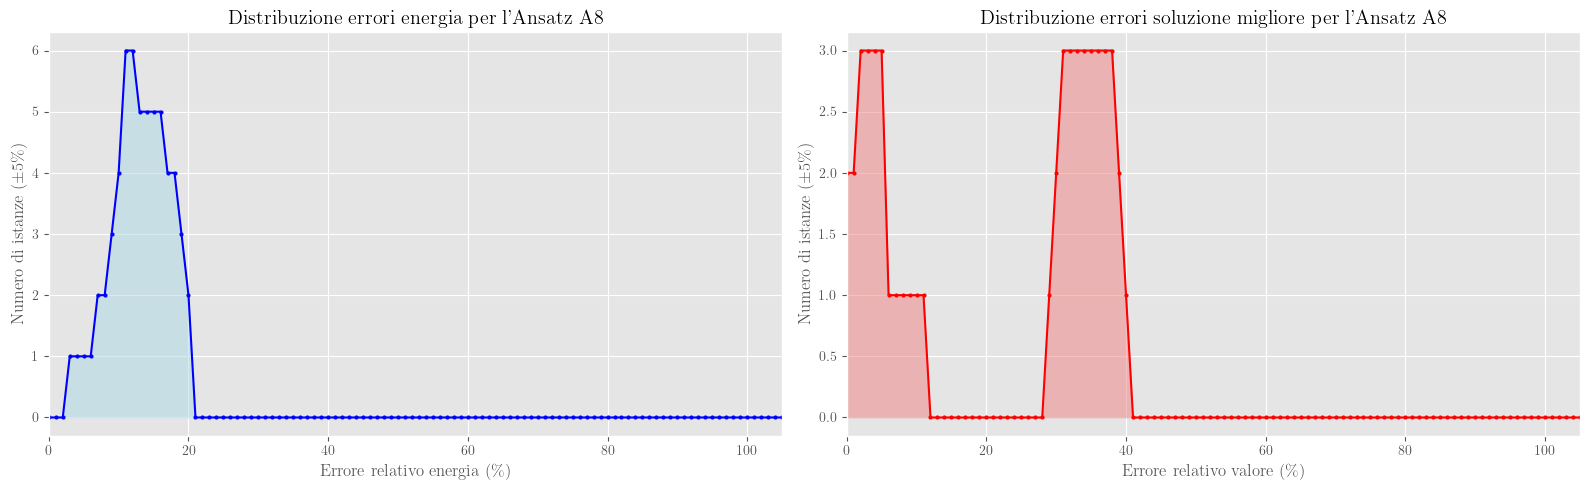

In [19]:
# ---------------------------
# Distribuzione dei risultati per l'ansatz migliore (utilizzando i dizionari già calcolati)
# ---------------------------

# Determina l'ansatz migliore in base all'errore relativo energia medio
best_ansatz = None
best_avg_energy_error = float('inf')
for ansatz in ansatz_names:
    errors = [energy_error_dict[ansatz][n] for n in problem_sizes]
    avg_error = np.mean(errors)
    if avg_error < best_avg_energy_error:
        best_avg_energy_error = avg_error
        best_ansatz = ansatz
print("Miglior ansatz (in termini di errore energia medio):", best_ansatz)

# Estrai i valori di errore per ciascuna istanza per il best ansatz
# Per l'energia usiamo l'errore relativo medio (energy_error_dict)
energy_error_values = [energy_error_dict[best_ansatz][n] for n in problem_sizes]
# Per il valore usiamo l'errore relativo della soluzione migliore (value_error_best_dict)
value_error_values  = [value_error_best_dict[best_ansatz][n] for n in problem_sizes]

# Definizione dei bin: centrati da -5 a 105 (passo 1)
bin_centers = np.arange(-5, 106, 1)

# Per ogni bin, conta il numero di istanze che hanno un errore entro ±5% dal centro
energy_counts = [sum(1 for error in energy_error_values if center - 5 <= error <= center + 5) for center in bin_centers]
value_counts  = [sum(1 for error in value_error_values if center - 5 <= error <= center + 5) for center in bin_centers]

# Grafici affiancati
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Grafico: Distribuzione errore relativo energia
axes[0].fill_between(bin_centers, energy_counts, color='lightblue', alpha=0.5)
axes[0].plot(bin_centers, energy_counts, color='blue', marker='o', markersize=2, linestyle='-')
axes[0].set_xlabel("Errore relativo energia (\%)")
axes[0].set_ylabel("Numero di istanze (±5\%)")
axes[0].set_title(f"Distribuzione errori energia per l'Ansatz {best_ansatz}")
axes[0].grid(True)
# Imposta i limiti dell'asse X per evitare valori negativi
axes[0].set_xlim(0, 105)

# Grafico: Distribuzione errore relativo soluzione migliore (valore)
axes[1].fill_between(bin_centers, value_counts, color='lightcoral', alpha=0.5)
axes[1].plot(bin_centers, value_counts, color='red', marker='o', markersize=2, linestyle='-')
axes[1].set_xlabel("Errore relativo valore (\%)")
axes[1].set_ylabel("Numero di istanze (±5\%)")
axes[1].set_title(f"Distribuzione errori soluzione migliore per l'Ansatz {best_ansatz}")
axes[1].grid(True)
axes[1].set_xlim(0, 105)

plt.tight_layout()
plt.show()



Istanze del TSP generate:
Numero di città: 3 -> Coordinate: [[6.96469186 2.86139335]
 [2.26851454 5.51314769]
 [7.1946897  4.2310646 ]]
Numero di città: 4 -> Coordinate: [[9.80764198 6.84829739]
 [4.80931901 3.92117518]
 [3.43178016 7.29049707]
 [4.38572245 0.59677897]]

===== Esecuzione per l'Ansatz A11 =====

Esecuzione VQE per il TSP con 3 città, Ansatz A11

--- Esecuzione VQE numero 1/3 ---
Tour ammissibile: [2, 1, 1]

--- Esecuzione VQE numero 2/3 ---
Tour non ammissibile
Tour VQE: [0, [1, 2], 0]
Tour classico: [0, 1, 2]
Tour non ammissibile

--- Esecuzione VQE numero 3/3 ---
Tour non ammissibile
Tour VQE: [[], [0, 2], 1]
Tour classico: [0, 1, 2]
Tour non ammissibile

Esecuzione VQE per il TSP con 4 città, Ansatz A11

--- Esecuzione VQE numero 1/3 ---
Tour non ammissibile
Tour VQE: [3, 2, 0, []]
Tour classico: [0, 2, 1, 3]
Tour non ammissibile

--- Esecuzione VQE numero 2/3 ---
Tour non ammissibile
Tour VQE: [2, 0, 3, []]
Tour classico: [0, 2, 1, 3]
Tour non ammissibile

--- Esecu

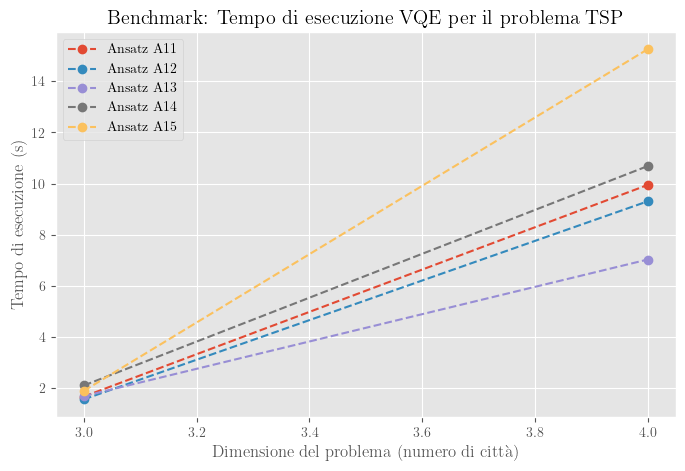

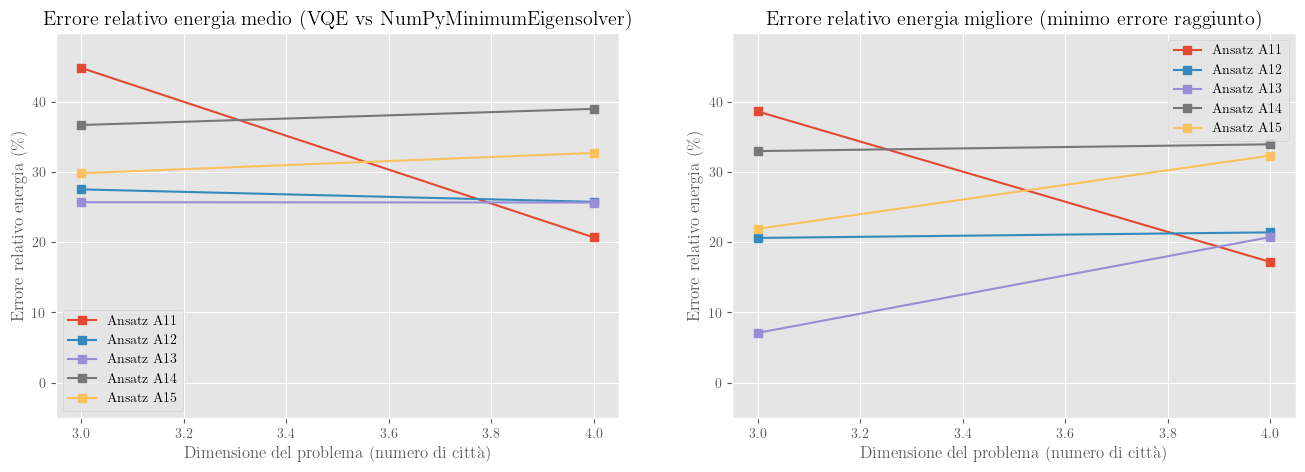

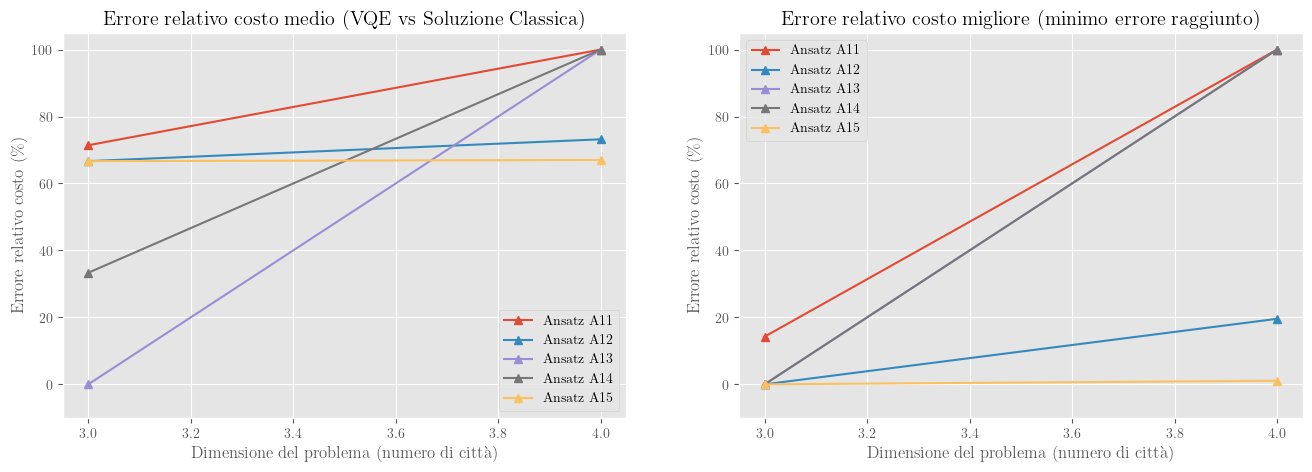

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Importazioni per Qiskit Optimization e algoritmi quantistici
from qiskit_optimization.applications.tsp import Tsp
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_aer.primitives import Sampler
from qiskit_algorithms.utils import algorithm_globals

from matplotlib import rc
# Setto il font a Computer Modern
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# ---------------------------
# Configurazione iniziale e seed
# ---------------------------
algorithm_globals.random_seed = 123
np.random.seed(123)  # Per la generazione casuale delle istanze

# Numero di esecuzioni VQE per ogni istanza
VQE_executions_per_instance = 3

# Parametri per la generazione delle istanze del TSP: numero di città
min_nodes = 3
max_nodes = 4

# ---------------------------
# Definizione di 5 diverse ansatz
# ---------------------------
def get_ansatz(ansatz_name, num_qubits):
    if ansatz_name == "A11":
        return TwoLocal(num_qubits, ['rx'], 'cx', reps=1, entanglement='full')
    elif ansatz_name == "A12":
        return TwoLocal(num_qubits, ['rx', 'rz'], 'cx', reps=1, entanglement='full')
    elif ansatz_name == "A13":
        return TwoLocal(num_qubits, ['rx', 'rz'], 'cz', reps=1, entanglement='full')
    elif ansatz_name == "A14":
        return TwoLocal(num_qubits, ['ry', 'rx', 'rz'], 'cx', reps=1, entanglement='full')
    elif ansatz_name == "A15":
        return TwoLocal(num_qubits, ['rx', 'rz'], 'cx', reps=2, entanglement='full')
    else:
        raise ValueError("Ansatz non riconosciuto")

# ---------------------------
# Generazione casuale delle istanze del TSP
# ---------------------------
tsp_instances = {}
print("Istanze del TSP generate:")
for n in range(min_nodes, max_nodes + 1):
    # Genero coordinate casuali in 2D (intervallo [0,10])
    coords = np.random.uniform(0, 10, size=(n, 2))
    # Calcolo la matrice delle distanze euclidea
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                dist_matrix[i, j] = np.linalg.norm(coords[i] - coords[j])
    tsp_instances[n] = (dist_matrix, coords)
    print(f"Numero di città: {n} -> Coordinate: {coords}")

# ---------------------------
# Funzione per risolvere un'istanza del TSP in modo classico (brute force)
# ---------------------------
from itertools import permutations
def solve_tsp_instance_classical(distance_matrix):
    n = len(distance_matrix)
    best_cost = np.inf
    best_tour = None
    # Fisso la città di partenza (0) per evitare duplicazioni
    for perm in permutations(range(1, n)):
        tour = [0] + list(perm)
        cost = 0
        for i in range(n - 1):
            cost += distance_matrix[tour[i], tour[i + 1]]
        cost += distance_matrix[tour[-1], tour[0]]  # ritorno alla città iniziale
        if cost < best_cost:
            best_cost = cost
            best_tour = tour
    return best_tour, best_cost

# ---------------------------
# Funzione per risolvere un'istanza del TSP con VQE
# ---------------------------
def solve_tsp_instance_VQE(distance_matrix, ansatz_name):
    # 1. Creazione del modello: costruzione del problema TSP
    tsp_app = Tsp(distance_matrix)
    qp = tsp_app.to_quadratic_program()
    
    # 2. Conversione in QUBO e in problema Ising
    qubo_converter = QuadraticProgramToQubo()
    qubo = qubo_converter.convert(qp)
    qubit_op, offset = qubo.to_ising()
    
    # 3. Definizione dell'ansatz in base al tipo scelto
    ansatz = get_ansatz(ansatz_name, qubit_op.num_qubits)
    
    # 4. Scelta dell'ottimizzatore (SPSA come esempio)
    optimizer = SPSA(maxiter=100)
    
    # 5. Creazione del VQE classico-quantistico
    vqe = SamplingVQE(
        sampler=Sampler(),
        optimizer=optimizer,
        ansatz=ansatz
    )
    
    start_time = time.time()
    result = vqe.compute_minimum_eigenvalue(qubit_op)
    elapsed_time = time.time() - start_time
    
    # 6. Interpretazione della soluzione: decodifica del bitstring
    # Il bitstring rappresenta una matrice binaria (dimensione n x n)
    binary_solution = tsp_app.sample_most_likely(result.eigenstate)
    tour = tsp_app.interpret(binary_solution)
    
    # Questo tour sarà composto da un indice per ogni movimento, dal primo all'ultimo
    # inoltre, se non è stato selezioato nulla per un movimento, l'elemtno sarà []
    # se più route sono state selezionate nella stessa volta, l'elemento sarà composto da [x,...,y]
    # dove x,...,y sono gli indici delle città selezionate
    
    # se il tour presenta array, vuoti o pieni, e non solo elementi, allora non è una soluzione ammissibile
    if any([type(t) != int for t in tour]):
        print("Tour non ammissibile")
        # print del tour trovato e del tour classicamente trovato
        print("Tour VQE:", tour)
        print("Tour classico:", solve_tsp_instance_classical(distance_matrix)[0])
        
        
        # Se il tour non è ammissibile, allora il costo del tour sarà impostato a
        # il massimo valore triplicato
        tour_cost = 3 * np.max(distance_matrix) * len(distance_matrix)
        # impostiamo il tour come una permutazione casuale
        tour = []
        return tour, tour_cost, result, elapsed_time, qubit_op, offset    
    
    print("Tour ammissibile:", tour)
    
    n = len(distance_matrix)  # Definizione di n (numero di città)
    # Calcolo del costo del tour
    tour_cost = 0
    for i in range(n - 1):
        tour_cost += distance_matrix[tour[i], tour[i + 1]]
    tour_cost += distance_matrix[tour[-1], tour[0]]
    
    return tour, tour_cost, result, elapsed_time, qubit_op, offset

# ---------------------------
# Ciclo sperimentale per ciascuna ansatz sulle stesse istanze TSP
# ---------------------------
ansatz_names = ["A11", "A12", "A13", "A14", "A15"]

# Inizializzo dei dizionari per raccogliere le metriche per ogni ansatz
execution_times_dict = {a: {} for a in ansatz_names}
energy_error_dict    = {a: {} for a in ansatz_names}      # errore energia medio (%)
cost_error_dict      = {a: {} for a in ansatz_names}        # errore costo tour medio (%)
energy_error_best_dict = {a: {} for a in ansatz_names}      # miglior errore energia (%)
cost_error_best_dict   = {a: {} for a in ansatz_names}        # miglior errore costo tour (%)

# Istanza di NumPyMinimumEigensolver per confronto energia
np_solver = NumPyMinimumEigensolver()

for ansatz in ansatz_names:
    print(f"\n===== Esecuzione per l'Ansatz {ansatz} =====")
    for num_nodes in sorted(tsp_instances.keys()):
        dist_matrix, coords = tsp_instances[num_nodes]
        print(f"\nEsecuzione VQE per il TSP con {num_nodes} città, Ansatz {ansatz}")
        
        # Risoluzione classica (brute force) una sola volta per l'istanza
        classical_tour, classical_cost = solve_tsp_instance_classical(dist_matrix)
        
        # Liste per raccogliere le metriche da più esecuzioni VQE
        times_list = []
        energy_error_list = []
        cost_error_list = []
        
        # Esecuzione multipla del VQE per l'istanza corrente
        for exec_num in range(VQE_executions_per_instance):
            print(f"\n--- Esecuzione VQE numero {exec_num+1}/{VQE_executions_per_instance} ---")
            tour, tour_cost, result, elapsed_time, qubit_op, offset = \
                solve_tsp_instance_VQE(dist_matrix, ansatz)
            
            # Calcolo dell'energia con NumPyMinimumEigensolver per confronto
            np_result = np_solver.compute_minimum_eigenvalue(operator=qubit_op)
            energy_np = np_result.eigenvalue.real
            energy_vqe = result.eigenvalue.real
            rel_error_energy = abs(energy_vqe - energy_np) / abs(energy_np) if energy_np != 0 else np.inf
            
            # stampa vero se non è una soluzione ammissibile
            if tour == []:
                print("Tour non ammissibile")
                rel_error_cost = 1
            else:
                # Calcolo dell'errore relativo sul costo del tour
                rel_error_cost = abs(classical_cost - tour_cost) / abs(classical_cost) if classical_cost != 0 else 0
            
            # Conversione in percentuali
            energy_error_percent = rel_error_energy * 100
            cost_error_percent = rel_error_cost * 100
            
            times_list.append(elapsed_time)
            energy_error_list.append(energy_error_percent)
            cost_error_list.append(cost_error_percent)
        
        # Calcolo delle medie delle metriche per l'istanza corrente
        avg_time = np.mean(times_list)
        avg_energy_error = np.mean(energy_error_list)
        avg_cost_error = np.mean(cost_error_list)
        
        # Calcolo dei valori migliori (minori errori)
        best_energy_error = np.min(energy_error_list)
        best_cost_error = np.min(cost_error_list)
        
        # Salvataggio delle metriche per l'ansatz corrente e per il numero di città
        execution_times_dict[ansatz][num_nodes] = avg_time
        energy_error_dict[ansatz][num_nodes] = avg_energy_error
        cost_error_dict[ansatz][num_nodes] = avg_cost_error
        energy_error_best_dict[ansatz][num_nodes] = best_energy_error
        cost_error_best_dict[ansatz][num_nodes] = best_cost_error

# ---------------------------
# Grafici comparativi per ciascuna metrica e per ciascuna ansatz
# ---------------------------
problem_sizes = sorted(tsp_instances.keys())
plt.style.use('ggplot')

# Grafico 1: Tempo di esecuzione medio
plt.figure(figsize=(8, 5))
for ansatz in ansatz_names:
    times = [execution_times_dict[ansatz][n] for n in problem_sizes]
    plt.plot(problem_sizes, times, marker='o', linestyle='--', label=f"Ansatz {ansatz}")
plt.xlabel("Dimensione del problema (numero di città)")
plt.ylabel("Tempo di esecuzione (s)")
plt.title("Benchmark: Tempo di esecuzione VQE per il problema TSP")
plt.legend()
plt.grid(True)
plt.show()

# Grafici 2 e 3: Errore relativo energia medio e migliore (affiancati)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
for ansatz in ansatz_names:
    errors_avg = [energy_error_dict[ansatz][n] for n in problem_sizes]
    axes[0].plot(problem_sizes, errors_avg, marker='s', linestyle='-', label=f"Ansatz {ansatz}")
axes[0].set_xlabel("Dimensione del problema (numero di città)")
axes[0].set_ylabel("Errore relativo energia (\%)")
axes[0].set_title("Errore relativo energia medio (VQE vs NumPyMinimumEigensolver)")
axes[0].legend()
axes[0].grid(True)

for ansatz in ansatz_names:
    errors_best = [energy_error_best_dict[ansatz][n] for n in problem_sizes]
    axes[1].plot(problem_sizes, errors_best, marker='s', linestyle='-', label=f"Ansatz {ansatz}")
axes[1].set_xlabel("Dimensione del problema (numero di città)")
axes[1].set_ylabel("Errore relativo energia (\%)")
axes[1].set_title("Errore relativo energia migliore (minimo errore raggiunto)")
axes[1].legend()
axes[1].grid(True)

all_energy_errors = (
    [energy_error_dict[a][n] for a in ansatz_names for n in problem_sizes] +
    [energy_error_best_dict[a][n] for a in ansatz_names for n in problem_sizes]
)
max_energy_error = max(all_energy_errors)
min_energy_error = min(all_energy_errors)
axes[0].set_ylim(min(-5, min_energy_error), max_energy_error+5)
axes[1].set_ylim(min(-5, min_energy_error), max_energy_error+5)

plt.show()

# Grafici 4 e 5: Errore relativo costo tour medio e migliore (affiancati)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
for ansatz in ansatz_names:
    errors_avg = [cost_error_dict[ansatz][n] for n in problem_sizes]
    axes[0].plot(problem_sizes, errors_avg, marker='^', linestyle='-', label=f"Ansatz {ansatz}")
axes[0].set_xlabel("Dimensione del problema (numero di città)")
axes[0].set_ylabel("Errore relativo costo (\%)")
axes[0].set_title("Errore relativo costo medio (VQE vs Soluzione Classica)")
axes[0].legend()
axes[0].grid(True)

for ansatz in ansatz_names:
    errors_best = [cost_error_best_dict[ansatz][n] for n in problem_sizes]
    axes[1].plot(problem_sizes, errors_best, marker='^', linestyle='-', label=f"Ansatz {ansatz}")
axes[1].set_xlabel("Dimensione del problema (numero di città)")
axes[1].set_ylabel("Errore relativo costo (\%)")
axes[1].set_title("Errore relativo costo migliore (minimo errore raggiunto)")
axes[1].legend()
axes[1].grid(True)

all_cost_errors = (
    [cost_error_dict[a][n] for a in ansatz_names for n in problem_sizes] +
    [cost_error_best_dict[a][n] for a in ansatz_names for n in problem_sizes]
)
max_cost_error = max(all_cost_errors)
min_cost_error = min(all_cost_errors)
axes[0].set_ylim(min(-5, min_cost_error-10), max_cost_error+5)
axes[1].set_ylim(min(-5, min_cost_error-10), max_cost_error+5)

plt.show()


Istanze del TSP generate:
Numero di città: 3 -> Coordinate: [[6.96469186 2.86139335]
 [2.26851454 5.51314769]
 [7.1946897  4.2310646 ]]
Numero di città: 4 -> Coordinate: [[9.80764198 6.84829739]
 [4.80931901 3.92117518]
 [3.43178016 7.29049707]
 [4.38572245 0.59677897]]

===== Esecuzione per l'Ansatz A11 =====

Esecuzione VQE per il TSP con 3 città, Ansatz A11

--- Esecuzione VQE numero 1/3 ---
Tour non ammissibile
Tour VQE: [1, 2, []]
Tour classico: [0, 1, 2]
Tour non ammissibile

--- Esecuzione VQE numero 2/3 ---
Tour non ammissibile
Tour VQE: [[], 0, 2]
Tour classico: [0, 1, 2]
Tour non ammissibile

--- Esecuzione VQE numero 3/3 ---
Tour ammissibile: [0, 1, 2]

Esecuzione VQE per il TSP con 4 città, Ansatz A11

--- Esecuzione VQE numero 1/3 ---
Tour non ammissibile
Tour VQE: [[], 3, 1, [0, 2]]
Tour classico: [0, 2, 1, 3]
Tour non ammissibile

--- Esecuzione VQE numero 2/3 ---
Tour non ammissibile
Tour VQE: [2, [], 1, 0]
Tour classico: [0, 2, 1, 3]
Tour non ammissibile

--- Esecuzion

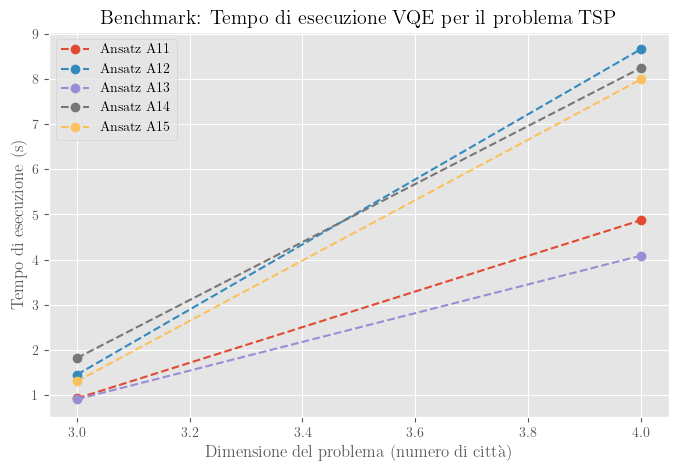

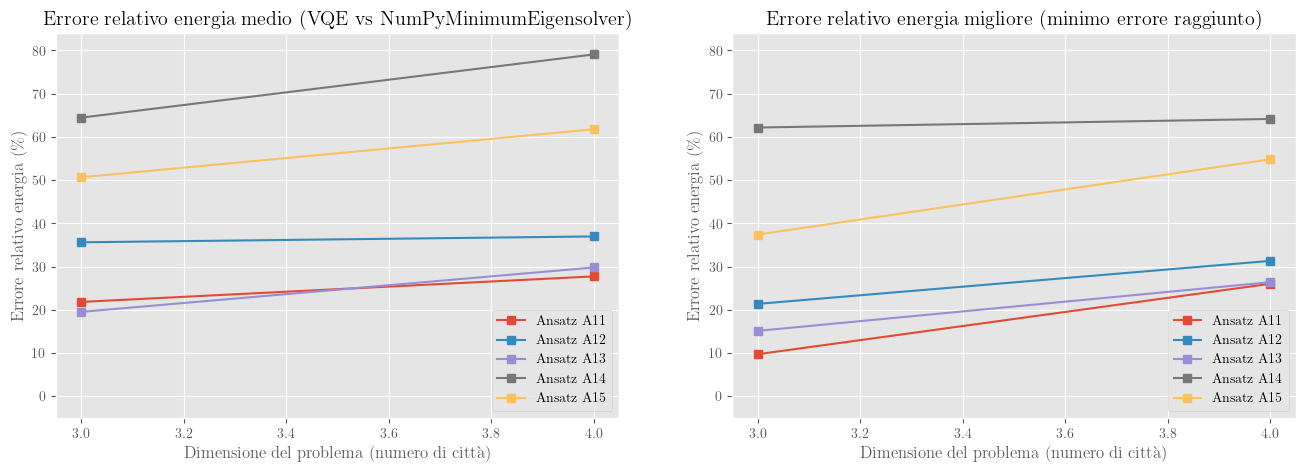

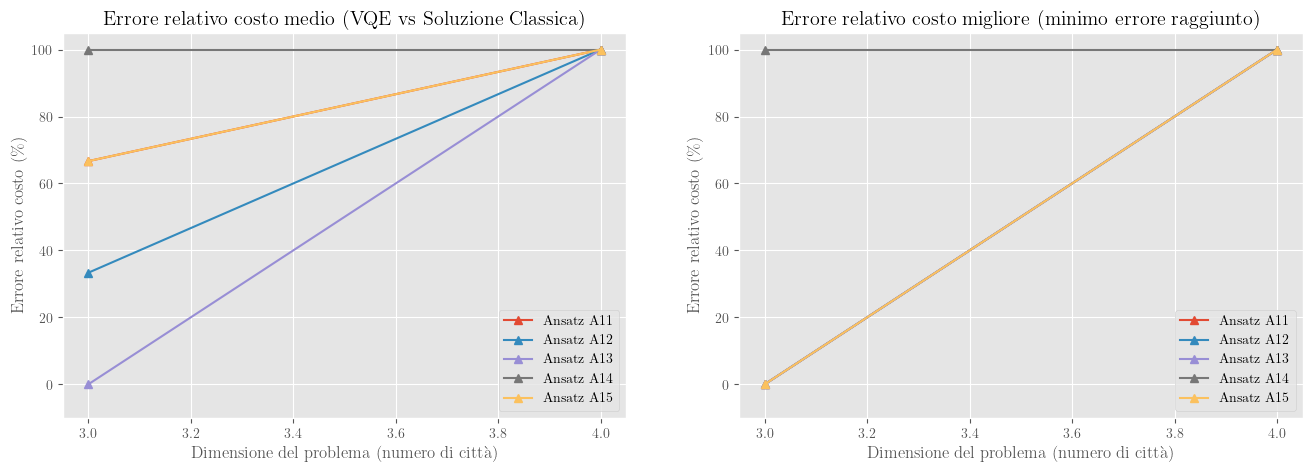

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Importazioni per Qiskit Optimization e algoritmi quantistici
from qiskit_optimization.applications.tsp import Tsp
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_aer.primitives import Sampler
from qiskit_algorithms.utils import algorithm_globals

from matplotlib import rc
# Setto il font a Computer Modern
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# ---------------------------
# Configurazione iniziale e seed
# ---------------------------
algorithm_globals.random_seed = 123
np.random.seed(123)  # Per la generazione casuale delle istanze

# Numero di esecuzioni VQE per ogni istanza
VQE_executions_per_instance = 3

# Parametri per la generazione delle istanze del TSP: numero di città
min_nodes = 3
max_nodes = 4

# ---------------------------
# Definizione di 5 diverse ansatz
# ---------------------------
def get_ansatz(ansatz_name, num_qubits):
    if ansatz_name == "A11":
        return TwoLocal(num_qubits, ['rx'], 'cx', reps=1, entanglement='full')
    elif ansatz_name == "A12":
        return TwoLocal(num_qubits, ['rx', 'rz'], 'cx', reps=1, entanglement='full')
    elif ansatz_name == "A13":
        return TwoLocal(num_qubits, ['rx', 'rz'], 'cz', reps=1, entanglement='full')
    elif ansatz_name == "A14":
        return TwoLocal(num_qubits, ['ry', 'rx', 'rz'], 'cx', reps=1, entanglement='full')
    elif ansatz_name == "A15":
        return TwoLocal(num_qubits, ['rx', 'rz'], 'cx', reps=2, entanglement='full')
    else:
        raise ValueError("Ansatz non riconosciuto")

# ---------------------------
# Generazione casuale delle istanze del TSP
# ---------------------------
tsp_instances = {}
print("Istanze del TSP generate:")
for n in range(min_nodes, max_nodes + 1):
    # Genero coordinate casuali in 2D (intervallo [0,10])
    coords = np.random.uniform(0, 10, size=(n, 2))
    # Calcolo la matrice delle distanze euclidea
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                dist_matrix[i, j] = np.linalg.norm(coords[i] - coords[j])
    tsp_instances[n] = (dist_matrix, coords)
    print(f"Numero di città: {n} -> Coordinate: {coords}")

# ---------------------------
# Funzione per risolvere un'istanza del TSP in modo classico (brute force)
# ---------------------------
from itertools import permutations
def solve_tsp_instance_classical(distance_matrix):
    n = len(distance_matrix)
    best_cost = np.inf
    best_tour = None
    # Fisso la città di partenza (0) per evitare duplicazioni
    for perm in permutations(range(1, n)):
        tour = [0] + list(perm)
        cost = 0
        for i in range(n - 1):
            cost += distance_matrix[tour[i], tour[i + 1]]
        cost += distance_matrix[tour[-1], tour[0]]  # ritorno alla città iniziale
        if cost < best_cost:
            best_cost = cost
            best_tour = tour
    return best_tour, best_cost

# ---------------------------
# Funzione per risolvere un'istanza del TSP con VQE
# ---------------------------
def solve_tsp_instance_VQE(distance_matrix, ansatz_name):
    # 1. Creazione del modello: costruzione del problema TSP
    tsp_app = Tsp(distance_matrix)
    qp = tsp_app.to_quadratic_program()
    
    # 2. Conversione in QUBO e in problema Ising
    qubo_converter = QuadraticProgramToQubo()
    qubo = qubo_converter.convert(qp)
    qubit_op, offset = qubo.to_ising()
    
    # 3. Definizione dell'ansatz in base al tipo scelto
    ansatz = get_ansatz(ansatz_name, qubit_op.num_qubits)
    
    # 4. Scelta dell'ottimizzatore (SPSA come esempio)
    optimizer = COBYLA(maxiter=100)
    
    # 5. Creazione del VQE classico-quantistico
    vqe = SamplingVQE(
        sampler=Sampler(),
        optimizer=optimizer,
        ansatz=ansatz
    )
    
    start_time = time.time()
    result = vqe.compute_minimum_eigenvalue(qubit_op)
    elapsed_time = time.time() - start_time
    
    # 6. Interpretazione della soluzione: decodifica del bitstring
    # Il bitstring rappresenta una matrice binaria (dimensione n x n)
    binary_solution = tsp_app.sample_most_likely(result.eigenstate)
    tour = tsp_app.interpret(binary_solution)
    
    # Questo tour sarà composto da un indice per ogni movimento, dal primo all'ultimo
    # inoltre, se non è stato selezioato nulla per un movimento, l'elemtno sarà []
    # se più route sono state selezionate nella stessa volta, l'elemento sarà composto da [x,...,y]
    # dove x,...,y sono gli indici delle città selezionate
    
    # se il tour presenta array, vuoti o pieni, e non solo elementi, allora non è una soluzione ammissibile
    if any([type(t) != int for t in tour]):
        print("Tour non ammissibile")
        # print del tour trovato e del tour classicamente trovato
        print("Tour VQE:", tour)
        print("Tour classico:", solve_tsp_instance_classical(distance_matrix)[0])
        
        
        # Se il tour non è ammissibile, allora il costo del tour sarà impostato a
        # il massimo valore triplicato
        tour_cost = 3 * np.max(distance_matrix) * len(distance_matrix)
        # impostiamo il tour come una permutazione casuale
        tour = []
        return tour, tour_cost, result, elapsed_time, qubit_op, offset    
    
    print("Tour ammissibile:", tour)
    
    n = len(distance_matrix)  # Definizione di n (numero di città)
    # Calcolo del costo del tour
    tour_cost = 0
    for i in range(n - 1):
        tour_cost += distance_matrix[tour[i], tour[i + 1]]
    tour_cost += distance_matrix[tour[-1], tour[0]]
    
    return tour, tour_cost, result, elapsed_time, qubit_op, offset

# ---------------------------
# Ciclo sperimentale per ciascuna ansatz sulle stesse istanze TSP
# ---------------------------
ansatz_names = ["A11", "A12", "A13", "A14", "A15"]

# Inizializzo dei dizionari per raccogliere le metriche per ogni ansatz
execution_times_dict = {a: {} for a in ansatz_names}
energy_error_dict    = {a: {} for a in ansatz_names}      # errore energia medio (%)
cost_error_dict      = {a: {} for a in ansatz_names}        # errore costo tour medio (%)
energy_error_best_dict = {a: {} for a in ansatz_names}      # miglior errore energia (%)
cost_error_best_dict   = {a: {} for a in ansatz_names}        # miglior errore costo tour (%)

# Istanza di NumPyMinimumEigensolver per confronto energia
np_solver = NumPyMinimumEigensolver()

for ansatz in ansatz_names:
    print(f"\n===== Esecuzione per l'Ansatz {ansatz} =====")
    for num_nodes in sorted(tsp_instances.keys()):
        dist_matrix, coords = tsp_instances[num_nodes]
        print(f"\nEsecuzione VQE per il TSP con {num_nodes} città, Ansatz {ansatz}")
        
        # Risoluzione classica (brute force) una sola volta per l'istanza
        classical_tour, classical_cost = solve_tsp_instance_classical(dist_matrix)
        
        # Liste per raccogliere le metriche da più esecuzioni VQE
        times_list = []
        energy_error_list = []
        cost_error_list = []
        
        # Esecuzione multipla del VQE per l'istanza corrente
        for exec_num in range(VQE_executions_per_instance):
            print(f"\n--- Esecuzione VQE numero {exec_num+1}/{VQE_executions_per_instance} ---")
            tour, tour_cost, result, elapsed_time, qubit_op, offset = \
                solve_tsp_instance_VQE(dist_matrix, ansatz)
            
            # Calcolo dell'energia con NumPyMinimumEigensolver per confronto
            np_result = np_solver.compute_minimum_eigenvalue(operator=qubit_op)
            energy_np = np_result.eigenvalue.real
            energy_vqe = result.eigenvalue.real
            rel_error_energy = abs(energy_vqe - energy_np) / abs(energy_np) if energy_np != 0 else np.inf
            
            # stampa vero se non è una soluzione ammissibile
            if tour == []:
                print("Tour non ammissibile")
                rel_error_cost = 1
            else:
                # Calcolo dell'errore relativo sul costo del tour
                rel_error_cost = abs(classical_cost - tour_cost) / abs(classical_cost) if classical_cost != 0 else 0
            
            # Conversione in percentuali
            energy_error_percent = rel_error_energy * 100
            cost_error_percent = rel_error_cost * 100
            
            times_list.append(elapsed_time)
            energy_error_list.append(energy_error_percent)
            cost_error_list.append(cost_error_percent)
        
        # Calcolo delle medie delle metriche per l'istanza corrente
        avg_time = np.mean(times_list)
        avg_energy_error = np.mean(energy_error_list)
        avg_cost_error = np.mean(cost_error_list)
        
        # Calcolo dei valori migliori (minori errori)
        best_energy_error = np.min(energy_error_list)
        best_cost_error = np.min(cost_error_list)
        
        # Salvataggio delle metriche per l'ansatz corrente e per il numero di città
        execution_times_dict[ansatz][num_nodes] = avg_time
        energy_error_dict[ansatz][num_nodes] = avg_energy_error
        cost_error_dict[ansatz][num_nodes] = avg_cost_error
        energy_error_best_dict[ansatz][num_nodes] = best_energy_error
        cost_error_best_dict[ansatz][num_nodes] = best_cost_error

# ---------------------------
# Grafici comparativi per ciascuna metrica e per ciascuna ansatz
# ---------------------------
problem_sizes = sorted(tsp_instances.keys())
plt.style.use('ggplot')

# Grafico 1: Tempo di esecuzione medio
plt.figure(figsize=(8, 5))
for ansatz in ansatz_names:
    times = [execution_times_dict[ansatz][n] for n in problem_sizes]
    plt.plot(problem_sizes, times, marker='o', linestyle='--', label=f"Ansatz {ansatz}")
plt.xlabel("Dimensione del problema (numero di città)")
plt.ylabel("Tempo di esecuzione (s)")
plt.title("Benchmark: Tempo di esecuzione VQE per il problema TSP")
plt.legend()
plt.grid(True)
plt.show()

# Grafici 2 e 3: Errore relativo energia medio e migliore (affiancati)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
for ansatz in ansatz_names:
    errors_avg = [energy_error_dict[ansatz][n] for n in problem_sizes]
    axes[0].plot(problem_sizes, errors_avg, marker='s', linestyle='-', label=f"Ansatz {ansatz}")
axes[0].set_xlabel("Dimensione del problema (numero di città)")
axes[0].set_ylabel("Errore relativo energia (\%)")
axes[0].set_title("Errore relativo energia medio (VQE vs NumPyMinimumEigensolver)")
axes[0].legend()
axes[0].grid(True)

for ansatz in ansatz_names:
    errors_best = [energy_error_best_dict[ansatz][n] for n in problem_sizes]
    axes[1].plot(problem_sizes, errors_best, marker='s', linestyle='-', label=f"Ansatz {ansatz}")
axes[1].set_xlabel("Dimensione del problema (numero di città)")
axes[1].set_ylabel("Errore relativo energia (\%)")
axes[1].set_title("Errore relativo energia migliore (minimo errore raggiunto)")
axes[1].legend()
axes[1].grid(True)

all_energy_errors = (
    [energy_error_dict[a][n] for a in ansatz_names for n in problem_sizes] +
    [energy_error_best_dict[a][n] for a in ansatz_names for n in problem_sizes]
)
max_energy_error = max(all_energy_errors)
min_energy_error = min(all_energy_errors)
axes[0].set_ylim(min(-5, min_energy_error), max_energy_error+5)
axes[1].set_ylim(min(-5, min_energy_error), max_energy_error+5)

plt.show()

# Grafici 4 e 5: Errore relativo costo tour medio e migliore (affiancati)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
for ansatz in ansatz_names:
    errors_avg = [cost_error_dict[ansatz][n] for n in problem_sizes]
    axes[0].plot(problem_sizes, errors_avg, marker='^', linestyle='-', label=f"Ansatz {ansatz}")
axes[0].set_xlabel("Dimensione del problema (numero di città)")
axes[0].set_ylabel("Errore relativo costo (\%)")
axes[0].set_title("Errore relativo costo medio (VQE vs Soluzione Classica)")
axes[0].legend()
axes[0].grid(True)

for ansatz in ansatz_names:
    errors_best = [cost_error_best_dict[ansatz][n] for n in problem_sizes]
    axes[1].plot(problem_sizes, errors_best, marker='^', linestyle='-', label=f"Ansatz {ansatz}")
axes[1].set_xlabel("Dimensione del problema (numero di città)")
axes[1].set_ylabel("Errore relativo costo (\%)")
axes[1].set_title("Errore relativo costo migliore (minimo errore raggiunto)")
axes[1].legend()
axes[1].grid(True)

all_cost_errors = (
    [cost_error_dict[a][n] for a in ansatz_names for n in problem_sizes] +
    [cost_error_best_dict[a][n] for a in ansatz_names for n in problem_sizes]
)
max_cost_error = max(all_cost_errors)
min_cost_error = min(all_cost_errors)
axes[0].set_ylim(min(-5, min_cost_error-10), max_cost_error+5)
axes[1].set_ylim(min(-5, min_cost_error-10), max_cost_error+5)

plt.show()


In [39]:
count_100 = 0
count_total = 0

for ans in cost_error_best_dict:
    for _, cost_err in cost_error_best_dict[ans].items():
        count_total += 1
        if cost_err == 100:
            count_100 += 1

percentage_not_admissible = (count_100 / count_total) * 100 if count_total else 0
print(f"Percentuale tour non ammissibili: {percentage_not_admissible:.2f}%")

# Trova tra A11, A12, A13, A14, A15 quali hanno trovato unicamente soluzioni inammissibili
ansatz_not_admissible = []
for ansatz in ansatz_names:
    not_admissible = all([cost_err == 100 for cost_err in cost_error_best_dict[ansatz].values()])
    if not_admissible:
        ansatz_not_admissible.append(ansatz)
print(f"Ansatz con soluzioni inammissibili: {ansatz_not_admissible}")

# stampa invece le ansatz che sono riuscite a trovare almeno una soluzione con 0 di errore
ansatz_with_zero_error = []
for ansatz in ansatz_names:
    zero_error = any([cost_err == 0 for cost_err in cost_error_best_dict[ansatz].values()])
    if zero_error:
        ansatz_with_zero_error.append(ansatz)
print(f"Ansatz con soluzioni a costo 0: {ansatz_with_zero_error}")

# Stampa degli errori relativi medi per A11
print("Errore relativo medio per A11:")
for n, err in cost_error_dict["A11"].items():
    print(f"Numero di città: {n} -> Errore relativo medio: {err:.2f}%")


Percentuale tour non ammissibili: 60.00%
Ansatz con soluzioni inammissibili: ['A14']
Ansatz con soluzioni a costo 0: ['A11']
Errore relativo medio per A11:
Numero di città: 3 -> Errore relativo medio: 66.67%
Numero di città: 4 -> Errore relativo medio: 100.00%
